# Clustering - Sleep Recommendations

This notebook is used to produce results related to clustering of data from the fitbit vitals data loaded from the corresponding pickle files and using sleep efficiency labels to then further find cluster impurities, distrinution and good sleep reciepes

## Importing Required Libraries

In [1]:
# Importing scientific libarires required for analysis and handling data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Importing libraries related to handling of files and directory
import os
import glob
import pickle
import random

# Importing utility functions from the code base
from utils.directory_utils import *
from utils.general_utils import *
from utils.sleep_utils import *
from data_preprocessor.get_user_data import *
from clustering_utils import *
from kmeans_dm import *

# Importing Machine Learning utilities
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.spatial import distance
from tslearn.metrics import dtw, cdist_dtw
from sklearn.metrics import silhouette_score
from scipy.stats import entropy

## Data

This section loads all different types of data from the pickle files that we have saved and then loads the relevant data into numpy array for further analysis

### Heart Rate, Sleep, Calories and Activity Time Series Data

#### User Data Loader

In [2]:
# First we load the data for each user seperately from their own numpy array and then stack them to get the final array
numpy_array_directory = f'../data/data_numpy_arrays/'

heart_rate_ts_data = []
calories_ts_data = []
activity_label_ts_data = []
activity_percentages = []
sleep_effeciency_ratio = []
sleep_stages_summary = []

for user_name in get_subdirectory_nms(numpy_array_directory):
#     if user_name in  ['Meghna\\']:
#         continue
    user_directory = construct_path(numpy_array_directory, user_name)

    user_heart_rate_ts_data = np.load(construct_path(user_directory, f'heart_rate_ts_data.npy'))
    user_calories_ts_data = np.load(construct_path(user_directory, f'calories_ts_data.npy'))
    user_activity_label_ts_data = np.load(construct_path(user_directory, f'activity_label_ts_data.npy'))
    user_activity_percentages = np.load(construct_path(user_directory, f'activity_percentages.npy'))
    user_sleep_effeciency_ratio = np.load(construct_path(user_directory, f'sleep_efficiency_ratio.npy'))
    user_sleep_stages_summary = pd.read_csv(construct_path(user_directory, f'sleep_stages_summary.csv'))

    heart_rate_ts_data.append(user_heart_rate_ts_data)
    calories_ts_data.append(user_calories_ts_data)
    activity_label_ts_data.append(user_activity_label_ts_data)
    activity_percentages.append(user_activity_percentages)
    sleep_effeciency_ratio.append(user_sleep_effeciency_ratio)
    sleep_stages_summary.append(user_sleep_stages_summary)

heart_rate_ts_data = np.vstack(heart_rate_ts_data)[:, :]
calories_ts_data = np.vstack(calories_ts_data)[:, :]
activity_label_ts_data = np.vstack(activity_label_ts_data)[:, :]
activity_percentages = np.vstack(activity_percentages)
sleep_effeciency_ratio = np.hstack(sleep_effeciency_ratio)
sleep_stages_summary = pd.concat(sleep_stages_summary)

In [3]:
activity_percentages = activity_percentages * 1440 / 100

#### Check for the shape of all the arrays and dataframes

In [4]:
# Check for the shape of all the arrays and dataframes
heart_rate_ts_data.shape, calories_ts_data.shape, activity_label_ts_data.shape, sleep_effeciency_ratio.shape, sleep_stages_summary.shape

((272, 1440), (272, 1440), (272, 1440), (272,), (272, 4))

In [5]:
# Make sure activity value does not have a nan field (not sure how we would fill this)
print(np.isnan(activity_label_ts_data).any())
# Check that no nans in any of the data
np.isnan(heart_rate_ts_data).any(), np.isnan(calories_ts_data).any()

False


(False, False)

# Transformations

This section uses different ways to transform the original time series data

### Heart Rate and Calories Trends

This section will essentially find the trends from the original data

In [6]:
trend_window_length = 10

#### Heart Trends

In [7]:
heart_trends = []
counter = 0
for day in heart_rate_ts_data:
    counter += 1
    result = seasonal_decompose(day, model='additive', freq=trend_window_length, extrapolate_trend='freq')
    heart_trends.append(result.trend)
heart_trends = np.array(heart_trends)
heart_trends = remove_nans_from_array(heart_trends)
# Make sure the shape is same and there are no nan values
heart_trends.shape, np.isnan(heart_trends).any()

((272, 1440), False)

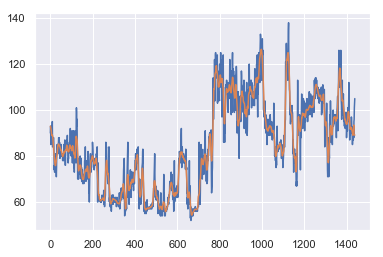

In [8]:
# plotting heart trends to asses the fit to the overall data
plt.plot(heart_rate_ts_data[0, :])
plt.plot(heart_trends[0, :])

#### Calories Trends

In [9]:
calories_trends = []
for day in calories_ts_data:
    result = seasonal_decompose(day, model='additive', freq=trend_window_length, extrapolate_trend='freq')
    calories_trends.append(result.trend)
calories_trends = np.array(calories_trends)
calories_trends = remove_nans_from_array(calories_trends)
# Make sure the shape is same and there are no nan values
calories_trends.shape, np.isnan(calories_trends).any()

((272, 1440), False)

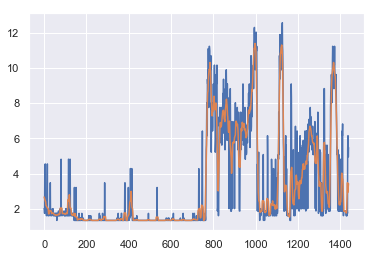

In [10]:
# plotting caloires trends to asses the fit to the overall data
plt.plot(calories_ts_data[0, :])
plt.plot(calories_trends[0, :])

# Chipping the Data

This section chips away some heart data

In [11]:
heart_trends = heart_trends[:, 360:1080]
calories_trends = calories_trends[:, 360:1080]
heart_trends.shape, calories_trends.shape

((272, 720), (272, 720))

### Dimensionality Reduction

This section will reduce the dimensions of the arrays so that we can easily apply different clustering techniques on them

In [12]:
mean_window_length = 15

In [13]:
# Reduce the dimension of the arrays
reduced_heart_trends = reduce_time_series_dimension(heart_trends, mean_window_length, hours=12)
reduced_calories_trends = reduce_time_series_dimension(calories_trends, mean_window_length, hours=12)
# Check for the shape of the arrays
reduced_heart_trends.shape, reduced_calories_trends.shape

((272, 48), (272, 48))

## Sleep Labels

In this section of the notebook we try to find the optimal boundary for constructing the sleep labels using different techniques

Text(0.5, 1.0, 'Sleep Efficiency Histogram')

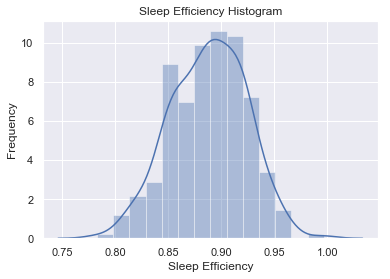

In [14]:
# Constructing a histogram plot for the sleep efficiency ratio.
# Sleep Efficiency Ratio is found as total_time_asleep / total_time_in_bed
sns.distplot(sleep_effeciency_ratio)
plt.xlabel('Sleep Efficiency')
plt.ylabel('Frequency')
plt.title('Sleep Efficiency Histogram')

Text(0.5, 1.0, 'Minutes in Deep Sleep Histogram')

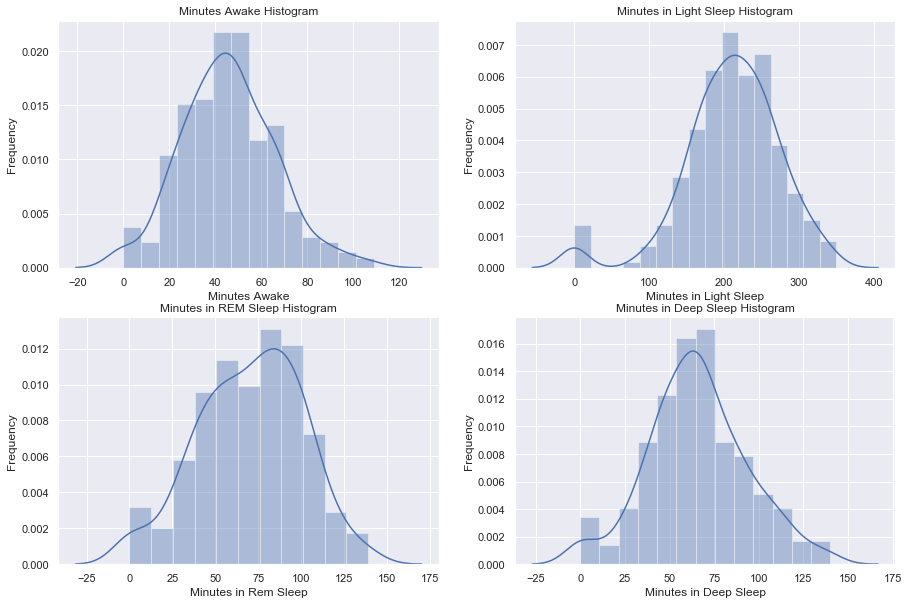

In [15]:
# Constructing a histogram plot for the different sleep stages.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(sleep_stages_summary['wake'], ax = ax[0, 0])
ax[0, 0].set_xlabel('Minutes Awake')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Minutes Awake Histogram')

sns.distplot(sleep_stages_summary['light'], ax = ax[0, 1])
ax[0, 1].set_xlabel('Minutes in Light Sleep')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Minutes in Light Sleep Histogram')

sns.distplot(sleep_stages_summary['rem'], ax = ax[1, 0])
ax[1, 0].set_xlabel('Minutes in Rem Sleep')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Minutes in REM Sleep Histogram')

sns.distplot(sleep_stages_summary['deep'], ax = ax[1, 1])
ax[1, 1].set_xlabel('Minutes in Deep Sleep')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Minutes in Deep Sleep Histogram')

### Gap Definition For Sleep Efficiency

Create a gap of certain length: Which will be a __parameter__

Example: 0.05 - 0.875 and above, 0.825 and below

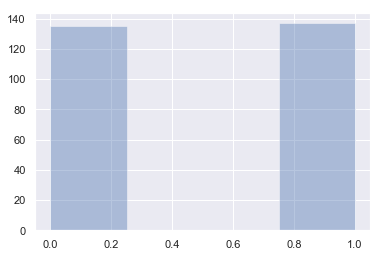

In [87]:
final_sleep_labels = sleep_effeciency_ratio > 0.89
sns.distplot(np.array(final_sleep_labels, dtype=np.int), kde=False)

### HeatMap for Euclidean and DTW Distances

In [18]:
good_sleep_heart_trends = reduced_heart_trends[final_sleep_labels]
poor_sleep_heart_trends = reduced_heart_trends[~final_sleep_labels]
print(good_sleep_heart_trends.shape, poor_sleep_heart_trends.shape)
ordered_heart_trends = np.vstack((good_sleep_heart_trends, poor_sleep_heart_trends))
print(ordered_heart_trends.shape)

(137, 48) (135, 48)
(272, 48)


In [19]:
good_sleep_calories_trends = reduced_calories_trends[final_sleep_labels]
poor_sleep_calories_trends = reduced_calories_trends[~final_sleep_labels]
print(good_sleep_calories_trends.shape, poor_sleep_calories_trends.shape)
ordered_calories_trends = np.vstack((good_sleep_calories_trends, poor_sleep_calories_trends))
print(ordered_calories_trends.shape)

(137, 48) (135, 48)
(272, 48)


In [20]:
%%time
dtw_dist_heart = cdist_dtw(ordered_heart_trends)
dtw_dist_calories = cdist_dtw(ordered_calories_trends)
euc_dist_heart = distance.cdist(ordered_heart_trends, ordered_heart_trends)
euc_dist_calories = distance.cdist(ordered_calories_trends, ordered_calories_trends)

Wall time: 4min 48s


In [21]:
m_dist_heart = distance.cdist(ordered_heart_trends, ordered_heart_trends, 'mahalanobis')
m_dist_calories = distance.cdist(ordered_calories_trends, ordered_calories_trends, 'mahalanobis')
l1_dist_heart = distance.cdist(ordered_heart_trends, ordered_heart_trends, 'minkowski', p=1)
l1_dist_calories = distance.cdist(ordered_calories_trends, ordered_calories_trends, 'minkowski', p=1)

Text(0.5, 1.0, 'All Sleep DTW Distance Cross Matrix for Calories Trends')

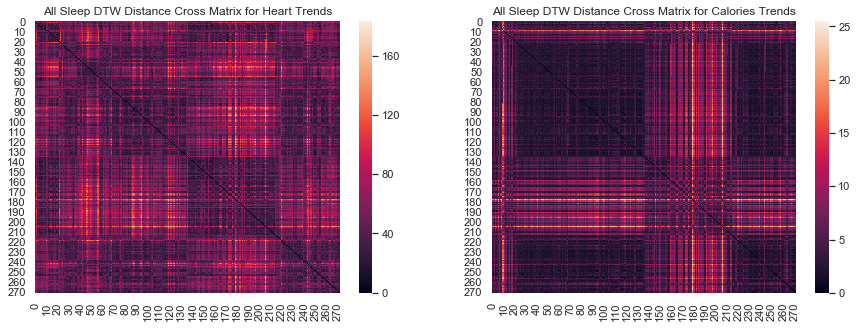

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(dtw_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep DTW Distance Cross Matrix for Heart Trends')
sns.heatmap(dtw_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep DTW Distance Cross Matrix for Calories Trends')

Text(0.5, 1.0, 'All Sleep Euclidean Distance Cross Matrix for Calories Trends')

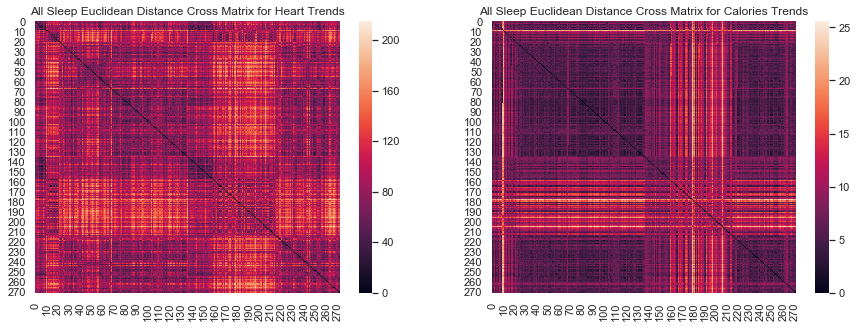

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(euc_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep Euclidean Distance Cross Matrix for Heart Trends')
sns.heatmap(euc_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep Euclidean Distance Cross Matrix for Calories Trends')

Text(0.5, 1.0, 'All Sleep Mahalanobis Distance Cross Matrix for Calories Trends')

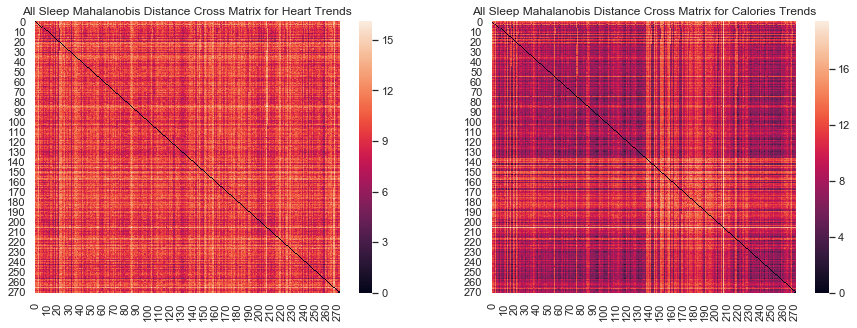

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(m_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep Mahalanobis Distance Cross Matrix for Heart Trends')
sns.heatmap(m_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep Mahalanobis Distance Cross Matrix for Calories Trends')

Text(0.5, 1.0, 'All Sleep L1 Norm Distance Cross Matrix for Calories Trends')

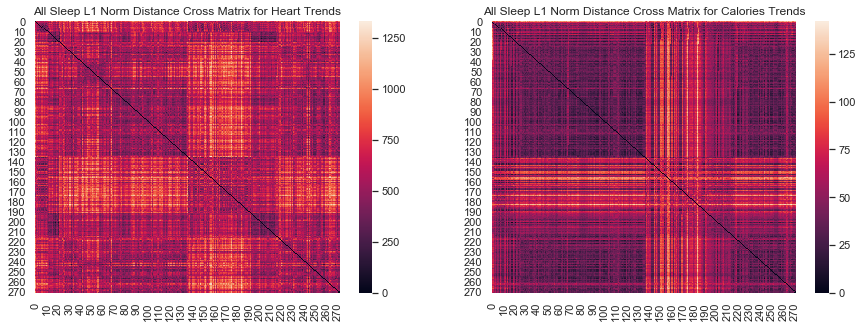

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(l1_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep L1 Norm Distance Cross Matrix for Heart Trends')
sns.heatmap(l1_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep L1 Norm Distance Cross Matrix for Calories Trends')

## Activity Percentages

In this section of the notebook we aggregate the activity labels of a person from minute level to percentage level

Text(0.5, 1.0, '% Vigorous Activity Histogram')

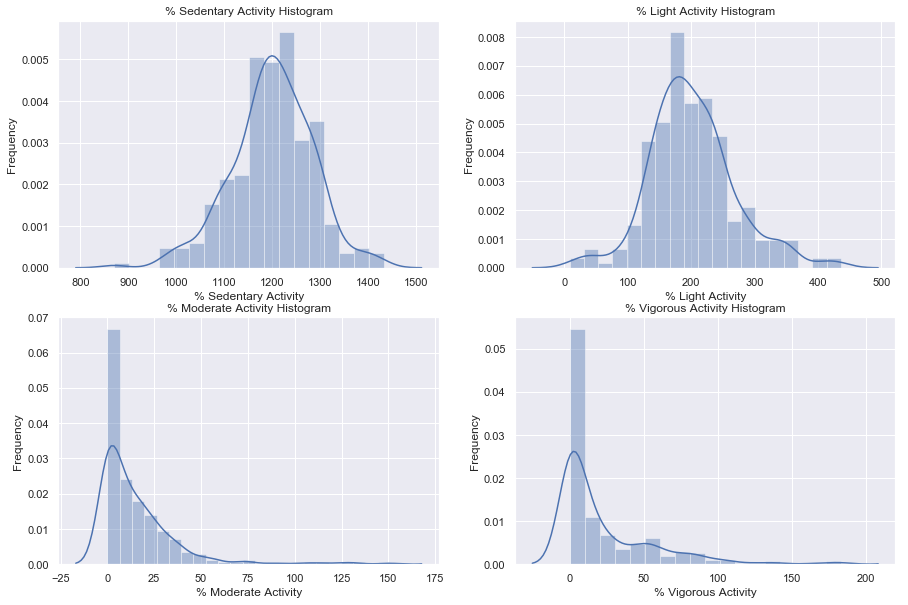

In [24]:
# Constructing a histogram plot for the different activity level percentages.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[:, 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[:, 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[:, 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[:, 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

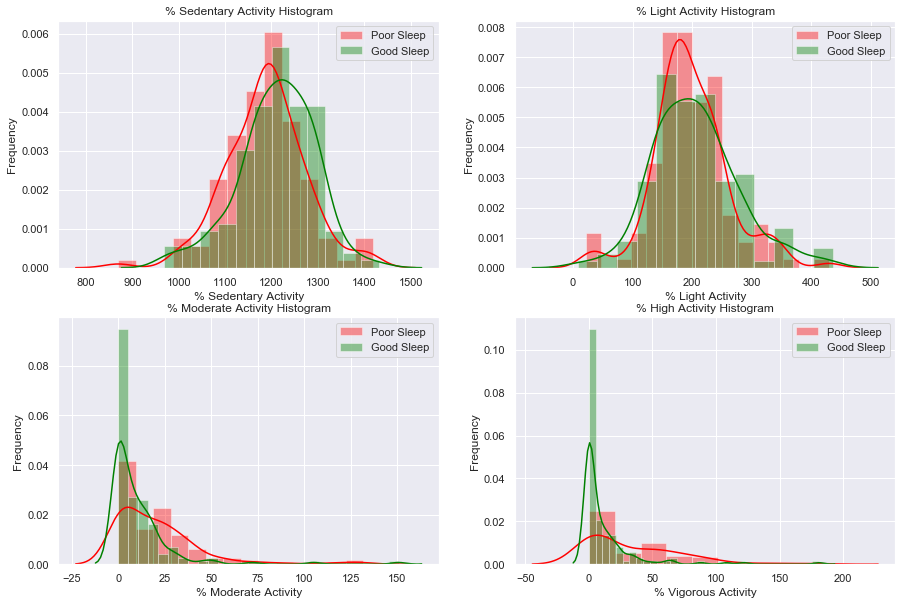

In [25]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[~final_sleep_labels, 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

## Clustering

In this section of the notebook we apply different clustering techniques on the data that we have got and see what are the different recipes

In [26]:
num_master_clusters = 4
num_activity_clusters = 8

### K-Means - Euclidean

Here we apply K-Means on the data with euclidean (L-2 Norm) as the distance metric

#### Getting the Best Model

In [27]:
kmeans_mod = get_best_clustering_model(lambda num_clusters: KMeans(num_clusters), reduced_heart_trends)

#### Fitting the Model

In [29]:
# Set the seed so that get the same clustering everytime
# random.seed(2)
# np.random.seed(1000)
# Performing the Clustering
# kmeans_mod = KMeans(n_clusters=num_master_clusters)
kmeans_mod.fit(reduced_heart_trends)
cluster_assignments = kmeans_mod.predict(reduced_heart_trends)
sil_score = silhouette_score(reduced_heart_trends, cluster_assignments)
print(kmeans_mod.n_clusters, sil_score)
np.unique(cluster_assignments, return_counts=True)

2 0.1860937699774176


(array([0, 1]), array([174,  98], dtype=int64))

In [30]:
# Update the number of activity clusters based on the minimum amount of records assigned to a cluster
num_activity_clusters = min(num_activity_clusters, *(np.unique(cluster_assignments, return_counts=True)[1]))
print('Updated Number of activity clusters:', num_activity_clusters)

Updated Number of activity clusters: 8


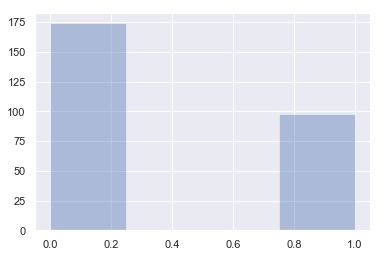

In [31]:
# Visualizing the number of points in each cluster
sns.distplot(cluster_assignments, kde=False)

#### Visualization of Clusters

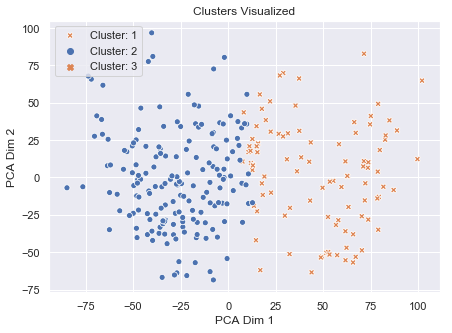

In [32]:
# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([f'Cluster: {i+1}' for i in range(4)])

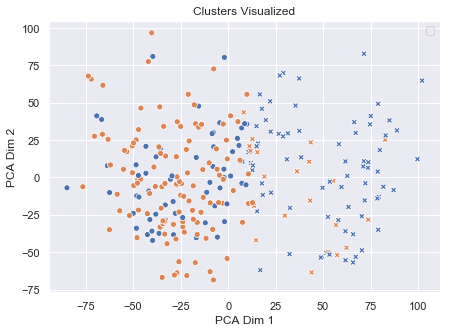

In [33]:
# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([])

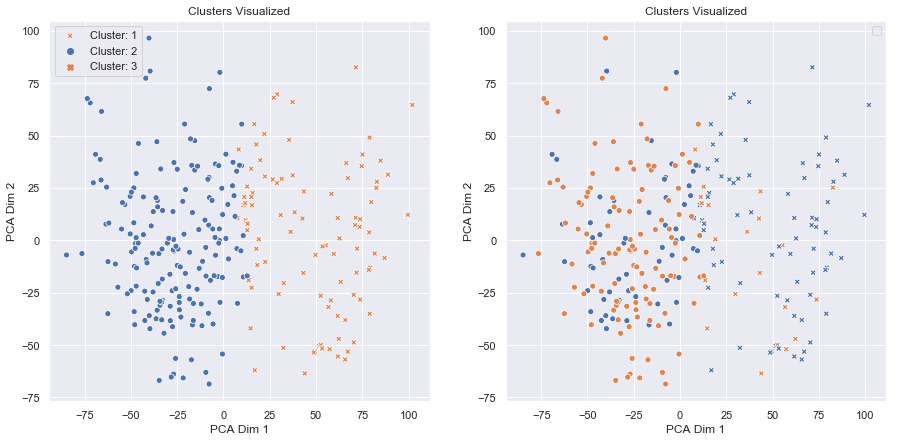

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, ax=ax[0])
ax[0].set_xlabel('PCA Dim 1')
ax[0].set_ylabel('PCA Dim 2')
ax[0].set_title('Clusters Visualized')
ax[0].legend([f'Cluster: {i+1}' for i in range(4)])

# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments, ax=ax[1])
ax[1].set_xlabel('PCA Dim 1')
ax[1].set_ylabel('PCA Dim 2')
ax[1].set_title('Clusters Visualized')
ax[1].legend([])

#### Cluster Purity

Finding cluster purity based on the sleep labels

In [36]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster 
# to total number of instances in the cluster
for master_cluster_num in range(len(kmeans_mod.cluster_centers_)):
    cluster_sleep_labels = final_sleep_labels[cluster_assignments == master_cluster_num]
    pos_sleep_label_purity = sum(cluster_sleep_labels) / cluster_sleep_labels.shape[0]
    print(f'Cluster Number: {master_cluster_num}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))

Cluster Number: 0, Purity: 0.6551724137931034
Cluster Number: 1, Purity: 0.7653061224489796


C:\Users\Saksham\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Saksham\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Cluster 4')

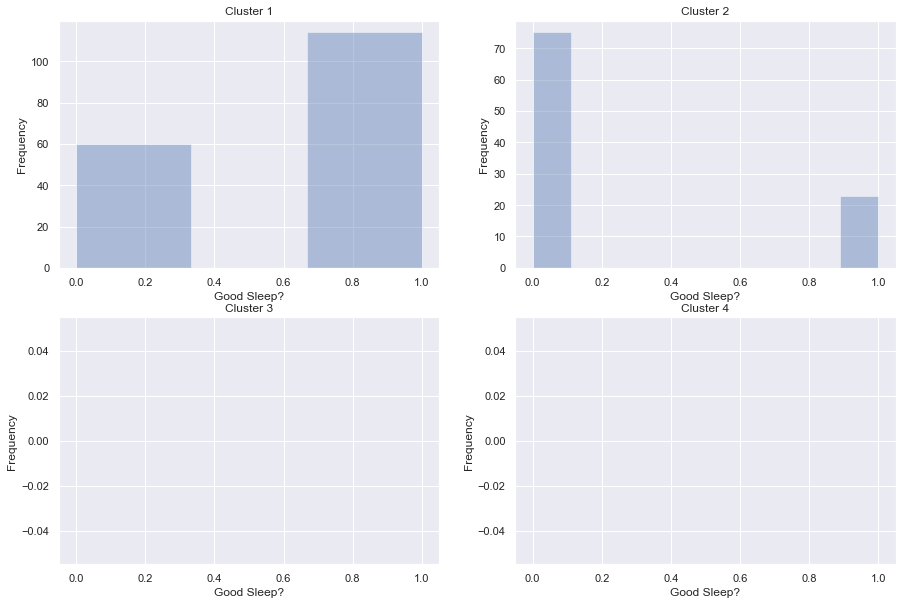

In [37]:
# Constructing a histogram plot for visualizing the sleep efficiency cluster purity in all cluster.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(np.array(final_sleep_labels[cluster_assignments==0], dtype=np.int16), ax = ax[0, 0], kde=False)
ax[0, 0].set_xlabel('Good Sleep?')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Cluster 1')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==1], dtype=np.int16), ax = ax[0, 1], kde=False)
ax[0, 1].set_xlabel('Good Sleep?')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Cluster 2')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==2], dtype=np.int16), ax = ax[1, 0], kde=False)
ax[1, 0].set_xlabel('Good Sleep?')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Cluster 3')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==3], dtype=np.int16), ax = ax[1, 1], kde=False)
ax[1, 1].set_xlabel('Good Sleep?')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Cluster 4')

#### Activity Histograms for Clusters

#### Cluster: 1

Text(0.5, 1.0, '% Vigorous Activity Histogram')

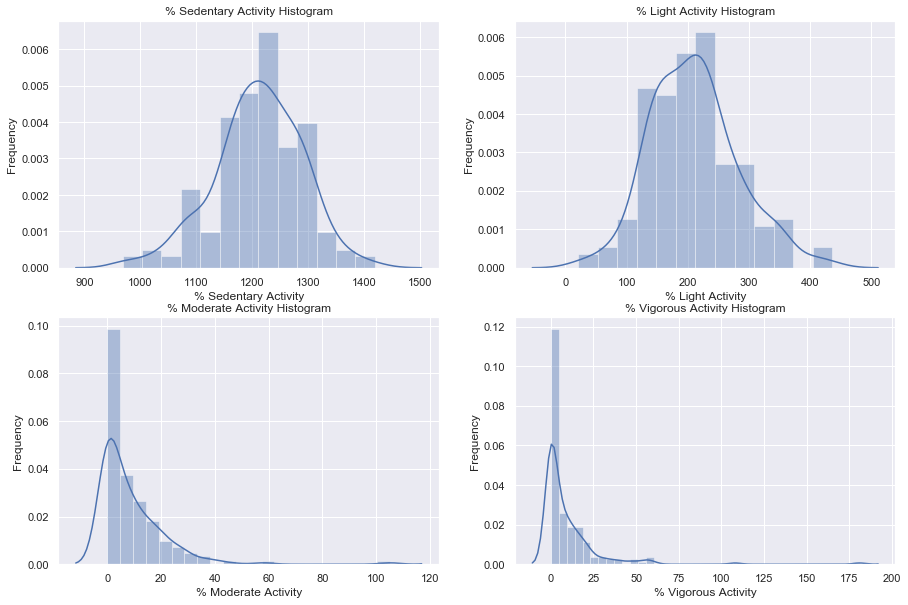

In [38]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

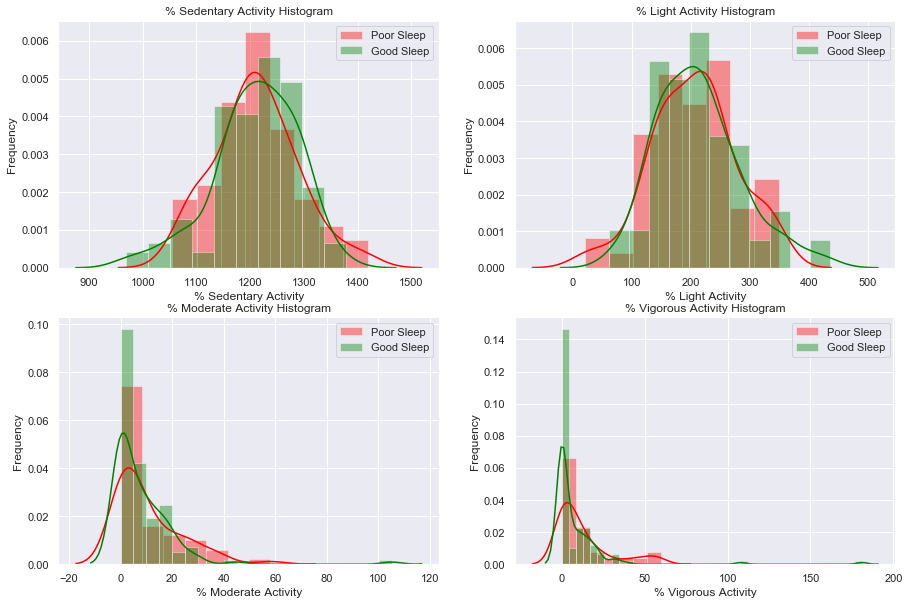

In [39]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 2

Text(0.5, 1.0, '% Vigorous Activity Histogram')

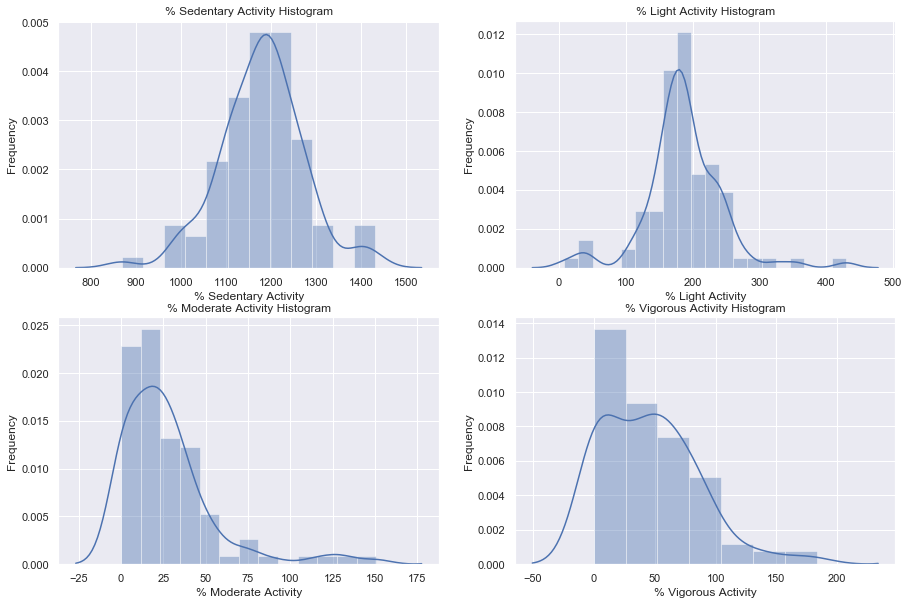

In [40]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

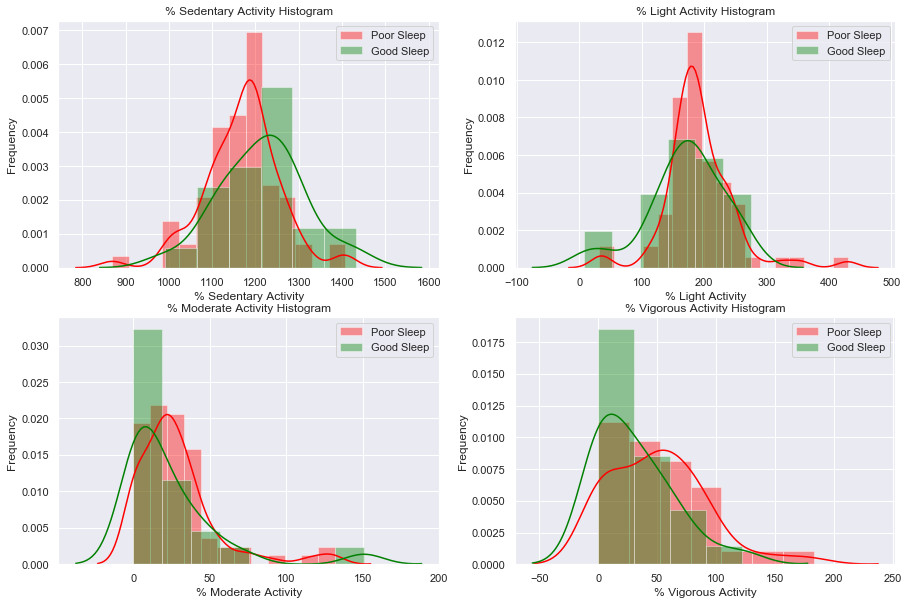

In [41]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 3

C:\Users\Saksham\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Saksham\Anaconda3\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, '% Vigorous Activity Histogram')

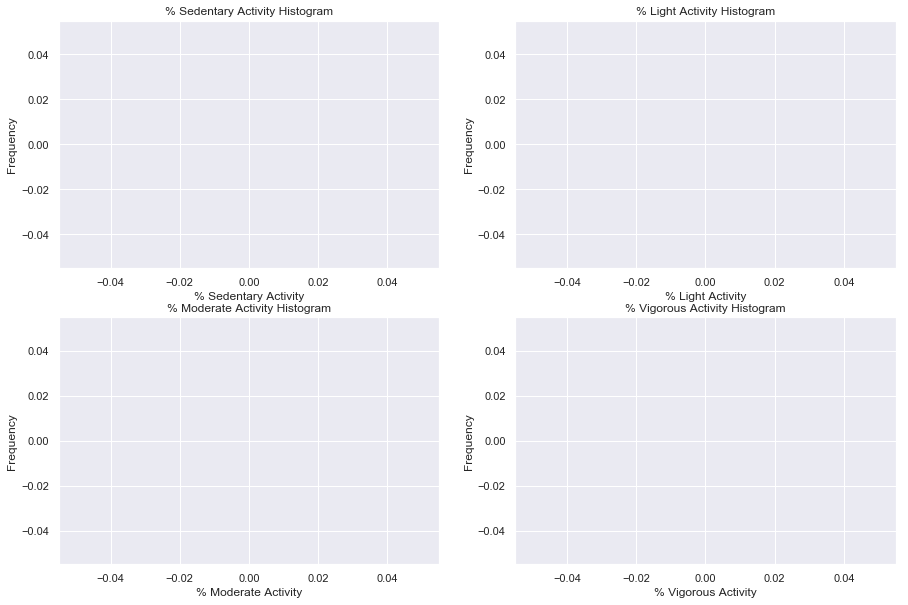

In [42]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

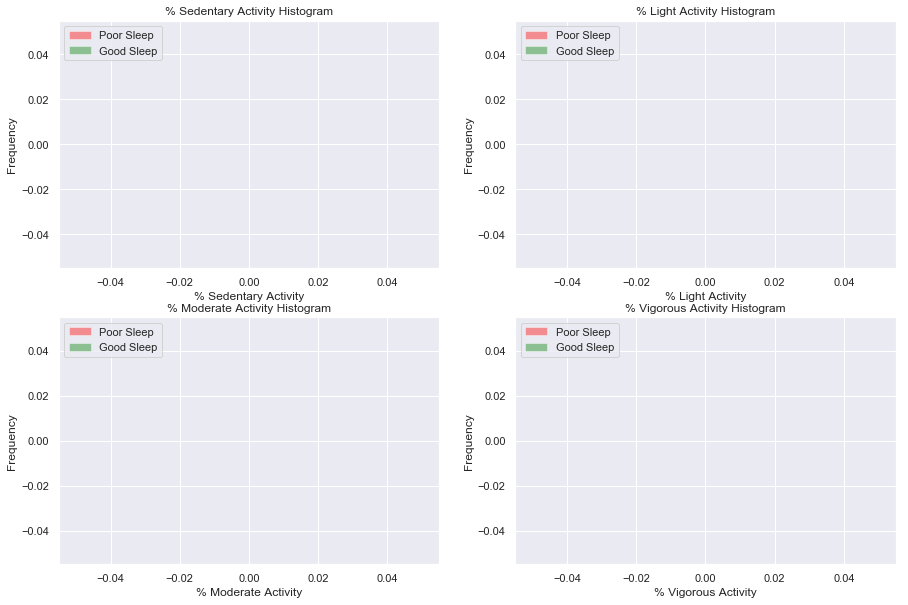

In [43]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 4

Text(0.5, 1.0, '% Vigorous Activity Histogram')

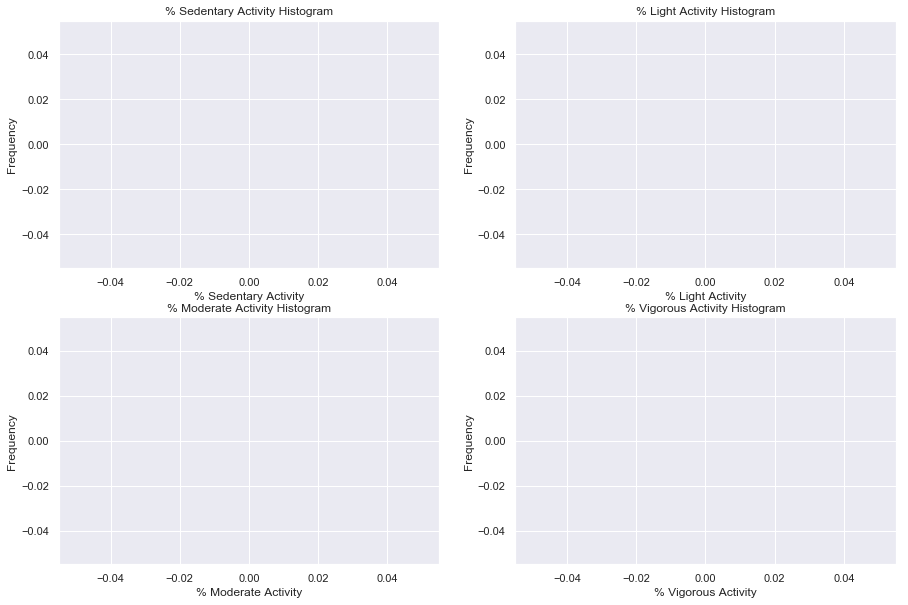

In [44]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

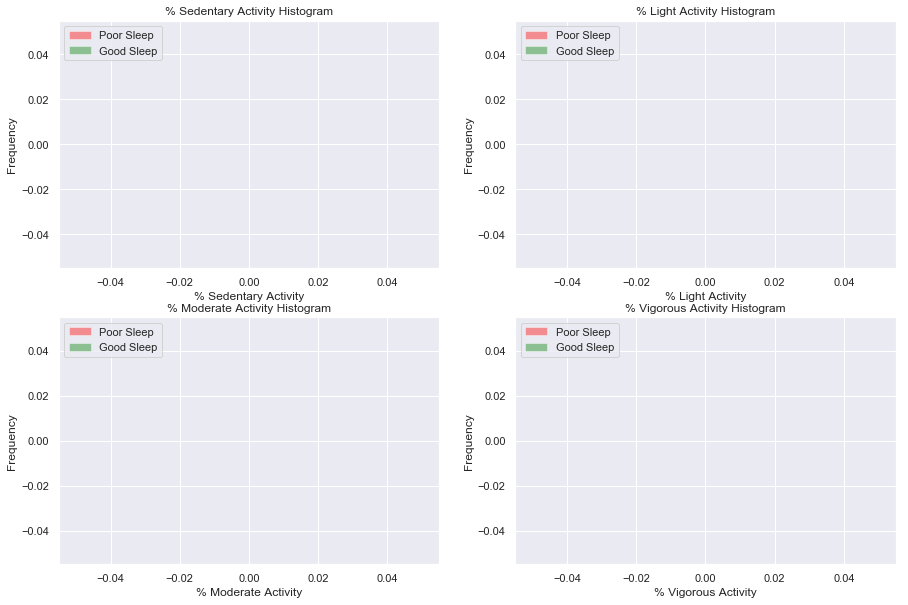

In [45]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Sub-Clustering on Activity Data

In [46]:
sub_clusters = activity_percentage_clusterer(KMeans(n_clusters=num_activity_clusters), cluster_assignments, activity_percentages)

In [47]:
# Sanity Check for the number of points in each cluster
print(np.unique(cluster_assignments, return_counts=True))
for sub_cluster in sub_clusters:
    print(sub_cluster.shape)

(array([0, 1]), array([174,  98], dtype=int64))
(174,)
(98,)


##### Cluster Purity in each subcluster

In [48]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster
# to total number of instances in the cluster
for index, sub_cluster in enumerate(sub_clusters):
    print('Master Cluster:', index+1)
    cluster_sleep_labels = final_sleep_labels[(cluster_assignments == index)]
    for sub_cluster_assignment in range(num_activity_clusters):
        sub_cluster_sleep_labels = cluster_sleep_labels[(sub_cluster==sub_cluster_assignment)]
        try:
            pos_sleep_label_purity = sum(sub_cluster_sleep_labels) / sub_cluster_sleep_labels.shape[0]
            print(f'Sub Cluster Number: {sub_cluster_assignment}, Purity:', max(pos_sleep_label_purity, 0))#, 1 - pos_sleep_label_purity))
        except:
            print(f'Sub Cluster Number: {sub_cluster_assignment}, No Points assigned')

Master Cluster: 1
Sub Cluster Number: 0, Purity: 0.5454545454545454
Sub Cluster Number: 1, Purity: 0.6808510638297872
Sub Cluster Number: 2, Purity: 0.6888888888888889
Sub Cluster Number: 3, Purity: 1.0
Sub Cluster Number: 4, Purity: 1.0
Sub Cluster Number: 5, Purity: 0.5
Sub Cluster Number: 6, Purity: 0.7142857142857143
Sub Cluster Number: 7, Purity: 0.25
Master Cluster: 2
Sub Cluster Number: 0, Purity: 0.14285714285714285
Sub Cluster Number: 1, Purity: 0.3125
Sub Cluster Number: 2, Purity: 0.5
Sub Cluster Number: 3, Purity: 0.18181818181818182
Sub Cluster Number: 4, Purity: 0.35
Sub Cluster Number: 5, Purity: 0.2
Sub Cluster Number: 6, Purity: 0.0
Sub Cluster Number: 7, Purity: 0.0


In [49]:
sleep_recipes = get_good_sleep_recipes(cluster_assignments, sub_clusters, activity_percentages, final_sleep_labels)
sleep_recipes

Cluster: 0, Sub Cluster: 1, Good Ratio: 2.1333333333333333
Cluster: 0, Sub Cluster: 2, Good Ratio: 2.2142857142857144
Cluster: 0, Sub Cluster: 3, Good Ratio: inf
Cluster: 0, Sub Cluster: 4, Good Ratio: inf
Cluster: 0, Sub Cluster: 6, Good Ratio: 2.5


array([[1167.1595   ,  255.79683  ,    8.248619 ,    8.770797 ],
       [1224.6388   ,  202.4274   ,    7.2185993,    5.583549 ],
       [1015.875    ,  401.23126  ,   11.988281 ,   10.72793  ],
       [ 968.4      ,  185.85     ,  105.13125  ,  181.0125   ],
       [1284.1799   ,  149.38126  ,    3.571465 ,    2.7980273]],
      dtype=float32)

<BarContainer object of 4 artists>

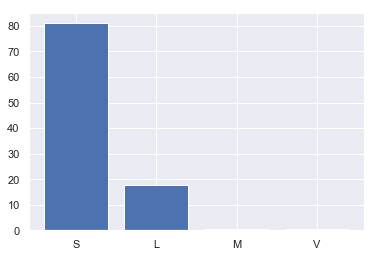

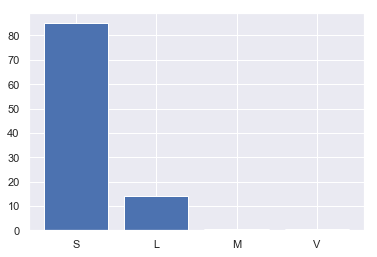

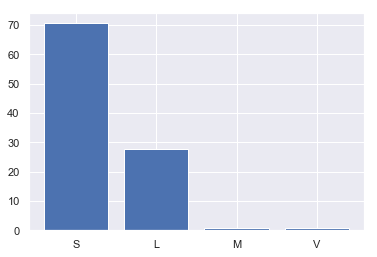

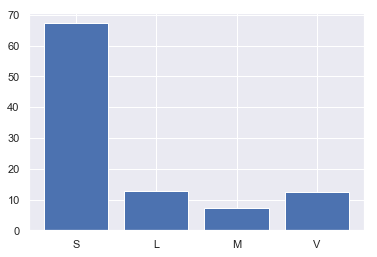

In [50]:
plt.figure(0)
plt.bar(['S', 'L', 'M', 'V'], (sleep_recipes / 1440 * 100)[0])
plt.figure(1)
plt.bar(['S', 'L', 'M', 'V'], (sleep_recipes / 1440 * 100)[1])
plt.figure(2)
plt.bar(['S', 'L', 'M', 'V'], (sleep_recipes / 1440 * 100)[2])
plt.figure(3)
plt.bar(['S', 'L', 'M', 'V'], (sleep_recipes / 1440 * 100)[3])


### K-Means - DTW

Here we apply K-Means on the data with Dynamic Time Wrapping (DTW) as the distance metric

In [51]:
num_activity_clusters = 8

#### Fitting the Model

In [52]:
clusterer = get_best_clustering_model(lambda num_clusters: TimeSeriesKMeans(num_clusters, metric='dtw', max_iter=50), 
                                       reduced_heart_trends, cluster_range=range(2, 5))

2073.926 --> 

KeyboardInterrupt: 

In [ ]:
clusterer

In [ ]:
clusterer.labels_

In [65]:
%%time
# Setting the seed
clusterer.fit(reduced_heart_trends)
cluster_assignments = clusterer.labels_
sil_score = silhouette_score(reduced_heart_trends, cluster_assignments)
print(clusterer.n_clusters, sil_score)
np.unique(cluster_assignments, return_counts=True)

2 0.18196322638456272
Wall time: 5.85 ms


In [66]:
print(np.unique(cluster_assignments, return_counts=True))

(array([0, 1], dtype=int64), array([107, 165], dtype=int64))


In [67]:
# Update the number of activity clusters based on the minimum amount of records assigned to a cluster
num_activity_clusters = min(num_activity_clusters, *(np.unique(cluster_assignments, return_counts=True)[1]))
print('Updated Number of activity clusters:', num_activity_clusters)

Updated Number of activity clusters: 8


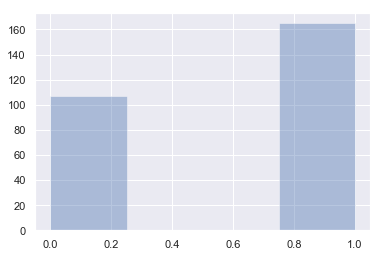

In [68]:
# Visualizing the number of points in each cluster
sns.distplot(cluster_assignments, kde=False)

#### Visualization of Clusters

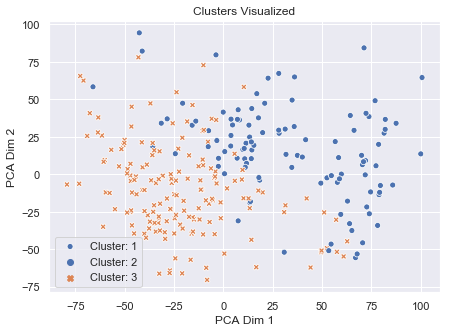

In [69]:
# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([f'Cluster: {i+1}' for i in range(4)])

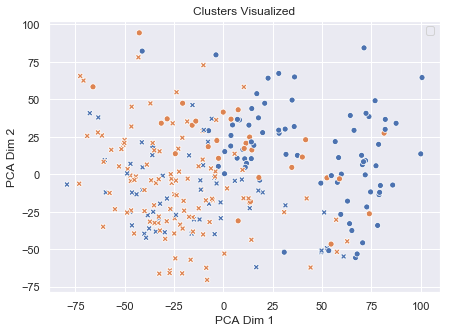

In [70]:
# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([])

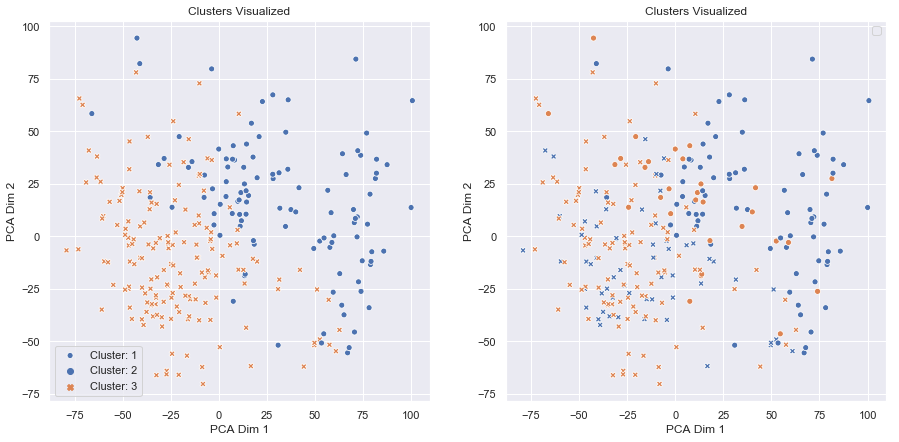

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, ax=ax[0])
ax[0].set_xlabel('PCA Dim 1')
ax[0].set_ylabel('PCA Dim 2')
ax[0].set_title('Clusters Visualized')
ax[0].legend([f'Cluster: {i+1}' for i in range(4)])

# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments, ax=ax[1])
ax[1].set_xlabel('PCA Dim 1')
ax[1].set_ylabel('PCA Dim 2')
ax[1].set_title('Clusters Visualized')
ax[1].legend([])

#### Cluster Purity

Finding cluster purity based on the sleep labels

In [74]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster 
# to total number of instances in the cluster
for master_cluster_num in np.unique(cluster_assignments):
    cluster_sleep_labels = final_sleep_labels[cluster_assignments == master_cluster_num]
    pos_sleep_label_purity = sum(cluster_sleep_labels) / cluster_sleep_labels.shape[0]
    print(f'Cluster Number: {master_cluster_num}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))

Cluster Number: 0, Purity: 0.719626168224299
Cluster Number: 1, Purity: 0.6484848484848484


C:\Users\Saksham\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Saksham\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Cluster 4')

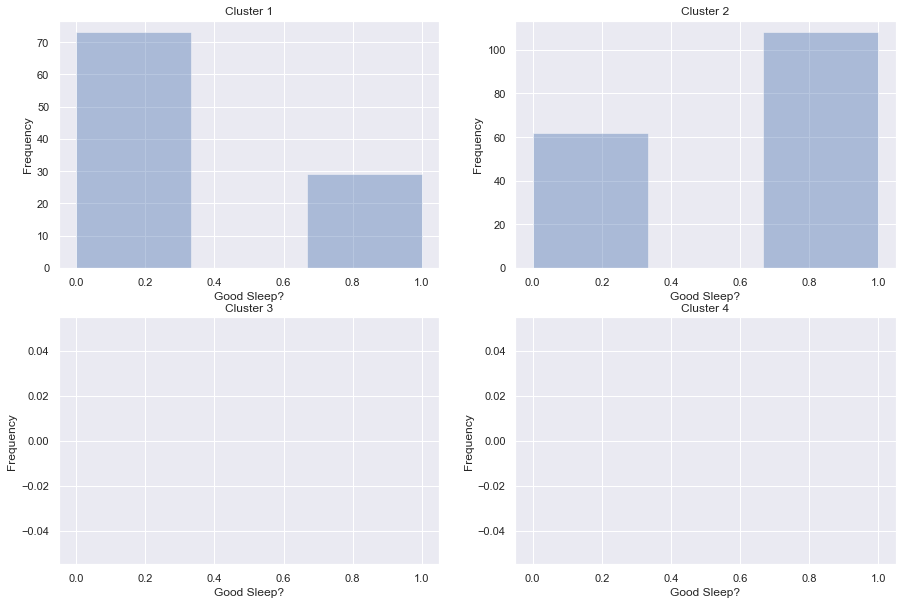

In [96]:
# Constructing a histogram plot for visualizing the sleep efficiency cluster purity in all cluster.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(np.array(final_sleep_labels[cluster_assignments==0], dtype=np.int16), ax = ax[0, 0], kde=False)
ax[0, 0].set_xlabel('Good Sleep?')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Cluster 1')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==1], dtype=np.int16), ax = ax[0, 1], kde=False)
ax[0, 1].set_xlabel('Good Sleep?')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Cluster 2')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==2], dtype=np.int16), ax = ax[1, 0], kde=False)
ax[1, 0].set_xlabel('Good Sleep?')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Cluster 3')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==3], dtype=np.int16), ax = ax[1, 1], kde=False)
ax[1, 1].set_xlabel('Good Sleep?')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Cluster 4')

#### Activity Histograms for Clusters

#### Cluster: 1

Text(0.5, 1.0, '% Vigorous Activity Histogram')

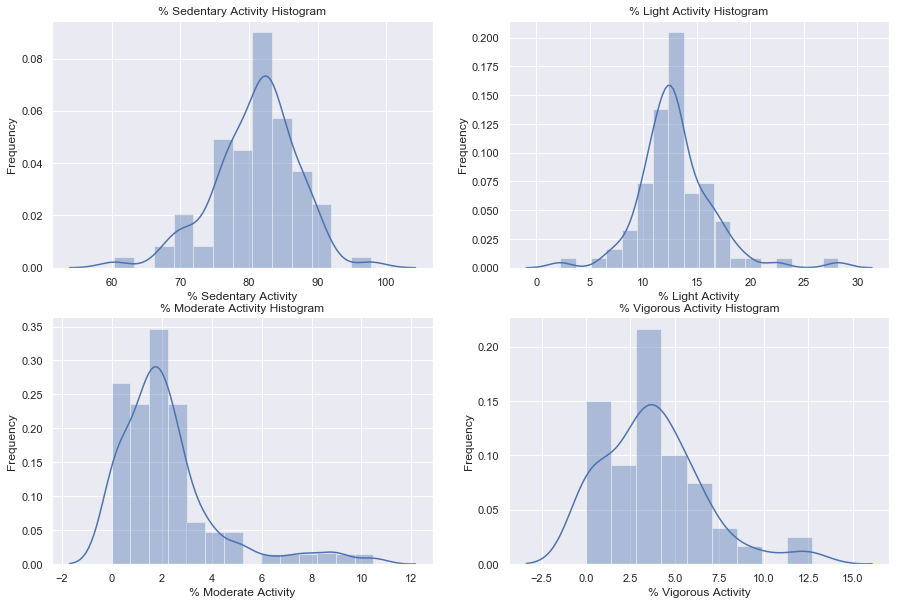

In [65]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

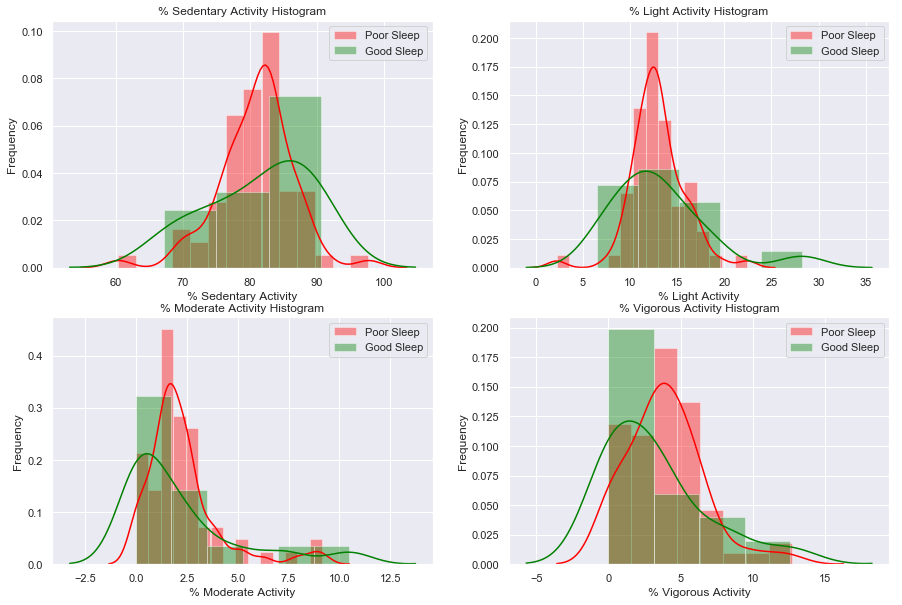

In [66]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 2

Text(0.5, 1.0, '% Vigorous Activity Histogram')

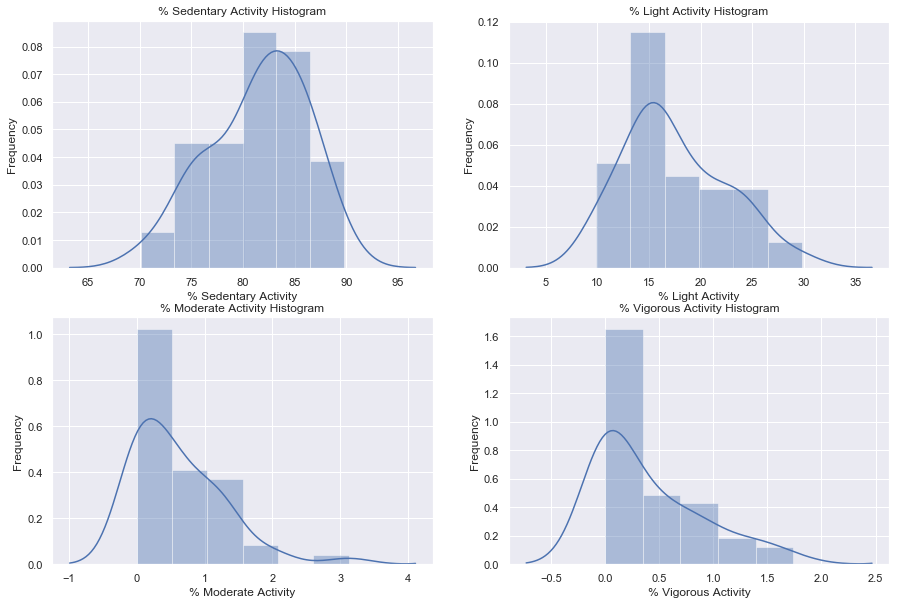

In [67]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

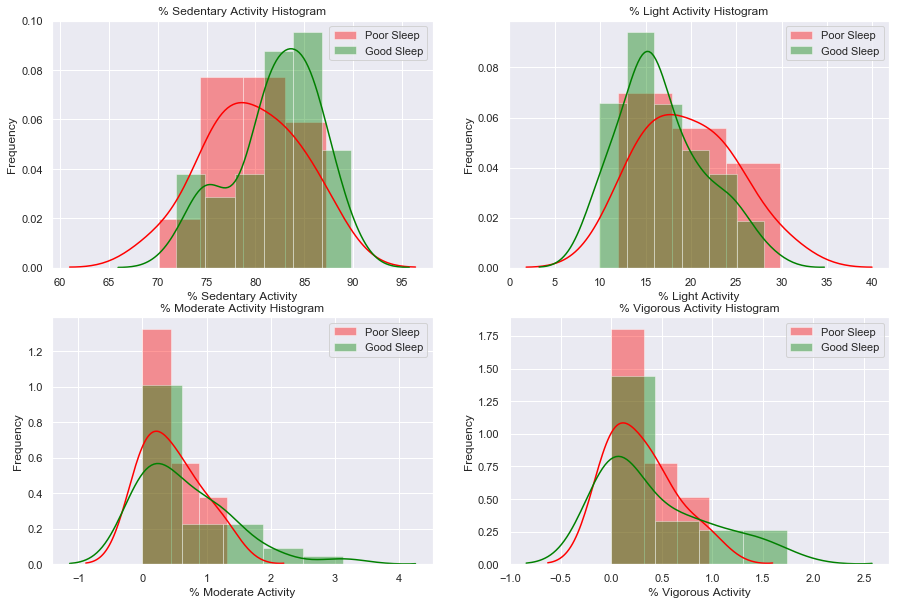

In [68]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 3

Text(0.5, 1.0, '% Vigorous Activity Histogram')

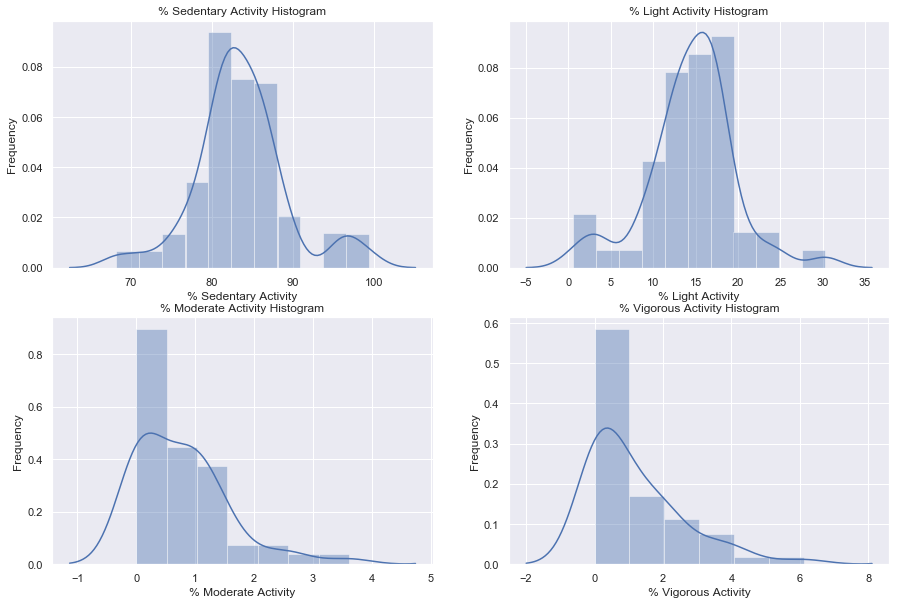

In [69]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

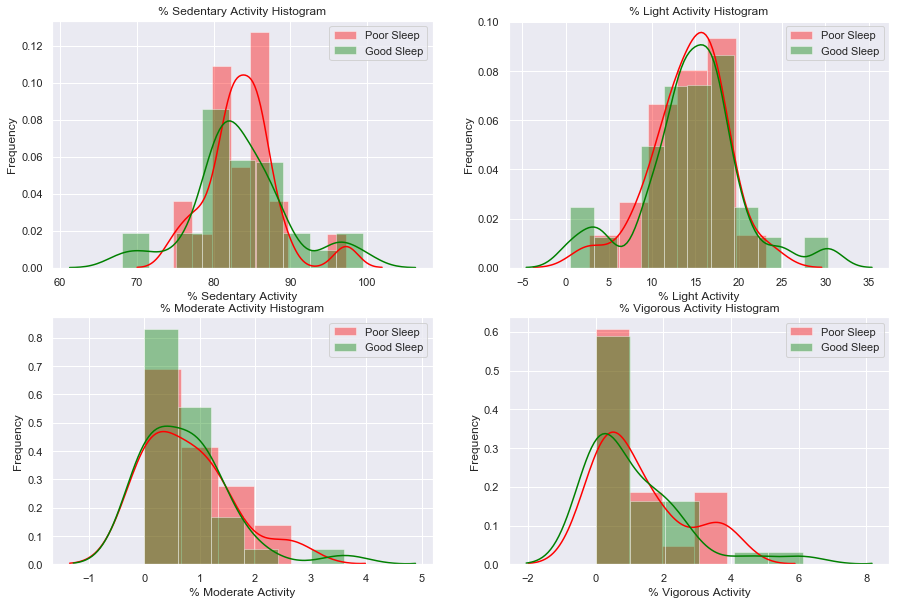

In [70]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 4

Text(0.5, 1.0, '% Vigorous Activity Histogram')

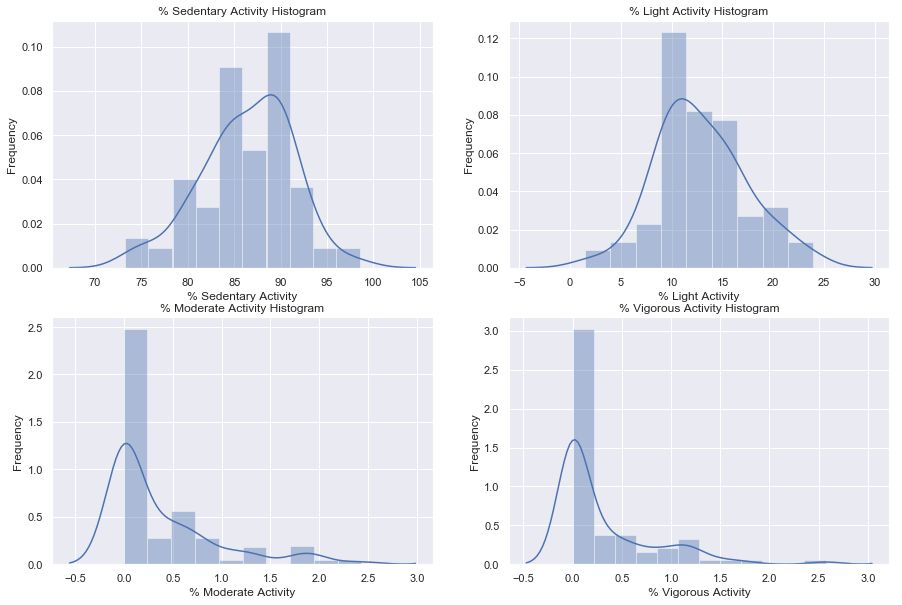

In [71]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

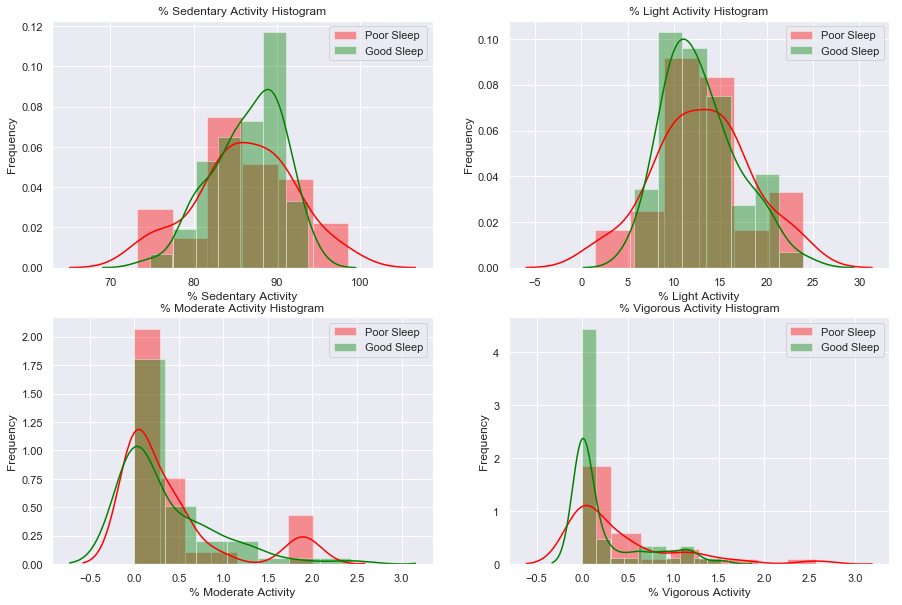

In [72]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Sub-Clustering on Activity Data

In [75]:
sub_clusters = activity_percentage_clusterer(TimeSeriesKMeans(num_activity_clusters, metric='dtw', max_iter=50), cluster_assignments, activity_percentages)

2024.084 --> 1633.619 --> 1566.092 --> 1555.393 --> 1555.393 --> 
1136.539 --> 958.523 --> 872.808 --> 842.940 --> 820.857 --> 811.949 --> 806.796 --> 799.560 --> 794.643 --> 789.039 --> 781.425 --> 777.462 --> 774.717 --> 768.324 --> 757.301 --> 751.612 --> 749.775 --> 748.059 --> 747.488 --> 746.872 --> 745.744 --> 745.426 --> 745.426 --> 


In [76]:
# Sanity Check for the number of points in each cluster
print(np.unique(cluster_assignments, return_counts=True))
for sub_cluster in sub_clusters:
    print(sub_cluster.shape)

(array([0, 1], dtype=int64), array([107, 165], dtype=int64))
(107,)
(165,)


##### Cluster Purity in each subcluster

In [78]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster
# to total number of instances in the cluster
for index, sub_cluster in enumerate(sub_clusters):
    print('Master Cluster:', index+1)
    cluster_sleep_labels = final_sleep_labels[(cluster_assignments == index)]
    for sub_cluster_assignment in range(num_activity_clusters):
        sub_cluster_sleep_labels = cluster_sleep_labels[(sub_cluster==sub_cluster_assignment)]
        try:
            pos_sleep_label_purity = sum(sub_cluster_sleep_labels) / sub_cluster_sleep_labels.shape[0]
            print(f'Sub Cluster Number: {sub_cluster_assignment}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))
        except:
            print(f'Sub Cluster Number: {sub_cluster_assignment}, No Points assigned')

Master Cluster: 1
Sub Cluster Number: 0, Purity: 0.8636363636363636
Sub Cluster Number: 1, Purity: 0.5652173913043479
Sub Cluster Number: 2, Purity: 0.6666666666666666
Sub Cluster Number: 3, Purity: 0.6666666666666667
Sub Cluster Number: 4, Purity: 0.9032258064516129
Sub Cluster Number: 5, Purity: 0.5714285714285714
Sub Cluster Number: 6, Purity: 0.5
Sub Cluster Number: 7, Purity: 1.0
Master Cluster: 2
Sub Cluster Number: 0, Purity: 0.7
Sub Cluster Number: 1, Purity: 0.6551724137931034
Sub Cluster Number: 2, Purity: 0.6666666666666666
Sub Cluster Number: 3, Purity: 0.5714285714285714
Sub Cluster Number: 4, Purity: 0.6428571428571429
Sub Cluster Number: 5, Purity: 0.7222222222222222
Sub Cluster Number: 6, Purity: 0.64
Sub Cluster Number: 7, Purity: 0.5806451612903226


In [79]:
sleep_recipes = get_good_sleep_recipes(cluster_assignments, sub_clusters, activity_percentages, final_sleep_labels)
sleep_recipes

Cluster: 0, Sub Cluster: 2, Good Ratio: 2.0
Cluster: 1, Sub Cluster: 0, Good Ratio: 2.3333333333333335
Cluster: 1, Sub Cluster: 2, Good Ratio: 2.0
Cluster: 1, Sub Cluster: 5, Good Ratio: 2.6


array([[1408.5      ,   26.06836  ,    2.520703 ,    3.0234375],
       [1150.457    ,  277.61786  ,    5.205134 ,    6.7181087],
       [1215.       ,  117.506256 ,   28.005468 ,   79.48125  ],
       [1226.1808   ,  202.0673   ,    6.651293 ,    4.923566 ]],
      dtype=float32)

### K-Means - KL Divergence

Here we apply K-Means on the data with K-L Divergence as the distance metric

#### Defining the distance function using the K-L Divergence

In [53]:
def k_l_distance(x, y):
    return (entropy(x, y) + entropy(y, x))/ 2

Text(0.5, 1.0, 'All Sleep K-L Divergence Cross Matrix for Calories Trends')

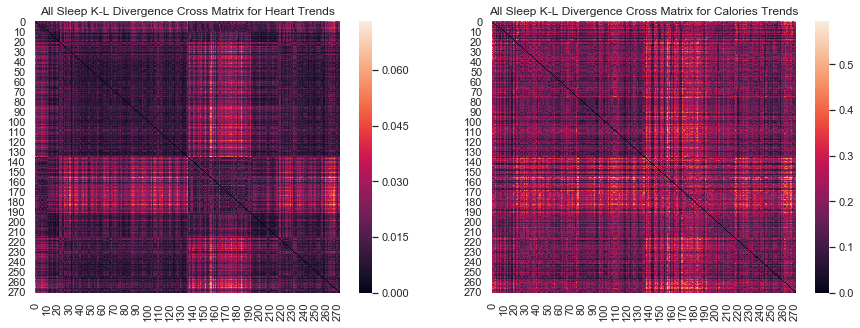

In [54]:
kl_dist_heart = cdist(ordered_heart_trends, ordered_heart_trends, metric=k_l_distance)
kl_dist_calories = cdist(ordered_calories_trends, ordered_calories_trends, metric=k_l_distance)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(kl_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep K-L Divergence Cross Matrix for Heart Trends')
sns.heatmap(kl_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep K-L Divergence Cross Matrix for Calories Trends')

#### Best Model

In [55]:
kl_best_mod = get_best_clustering_model(lambda num_clusters: KL_Kmeans(num_clusters), reduced_heart_trends, 
                                        sil_score_distance_metric=k_l_distance)

kmeans: X (272, 48)  centres (2, 48)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AC3F5B00>>
kmeans: 7 iterations  cluster sizes: [168 104]
kmeans: X (272, 48)  centres (3, 48)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AAA72C18>>
kmeans: 6 iterations  cluster sizes: [130  88  54]
kmeans: X (272, 48)  centres (4, 48)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AC9BDD68>>
kmeans: 8 iterations  cluster sizes: [86 77 54 55]
kmeans: X (272, 48)  centres (5, 48)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AAA72C18>>
kmeans: 11 iterations  cluster sizes: [58 76 51 57 30]
kmeans: X (272, 48)  centres (6, 48)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x

#### Fitting the Model

In [56]:
# Set the seed so that get the same clustering everytime
# random.seed(2)
# np.random.seed(1000)
# Performing the Clustering
# randomcentres = randomsample(reduced_heart_trends, kl_best_mod.get_num_clusters())
randomcentres = randomsample(reduced_heart_trends, 4)
centres, cluster_assignments, dist = kmeans(reduced_heart_trends, randomcentres, metric=k_l_distance, maxiter=200)
sil_score = silhouette_score(reduced_heart_trends, cluster_assignments, metric=k_l_distance)
print(len(centres), sil_score)
np.unique(cluster_assignments, return_counts=True)

kmeans: X (272, 48)  centres (4, 48)  delta=0.001  maxiter=200  metric=<function k_l_distance at 0x00000211AAFE1D90>
kmeans: 8 iterations  cluster sizes: [113  76  27  56]
4 0.20755318416116436


(array([0, 1, 2, 3], dtype=int64), array([113,  76,  27,  56], dtype=int64))

In [57]:
# Update the number of activity clusters based on the minimum amount of records assigned to a cluster
num_activity_clusters = min(num_activity_clusters, *(np.unique(cluster_assignments, return_counts=True)[1]))
print('Updated Number of activity clusters:', num_activity_clusters)

Updated Number of activity clusters: 8


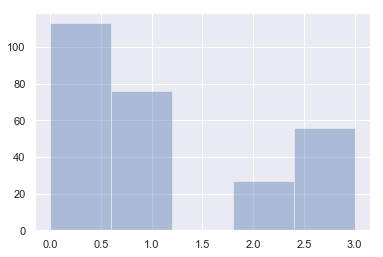

In [58]:
# Visualizing the number of points in each cluster
sns.distplot(cluster_assignments, kde=False)

#### Visualization of Clusters

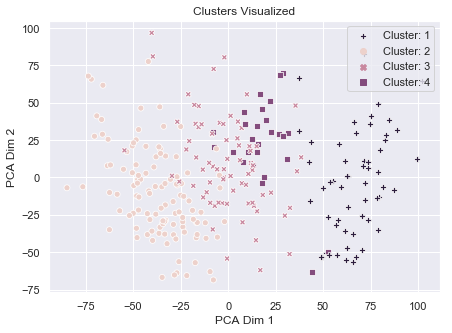

In [59]:
# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([f'Cluster: {i+1}' for i in range(4)])

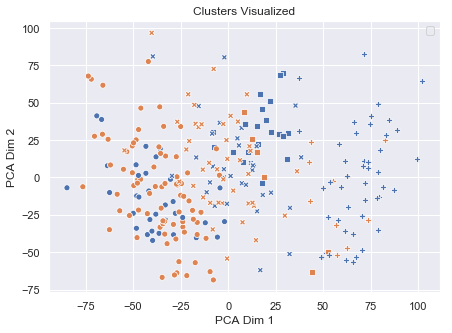

In [60]:
# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([])

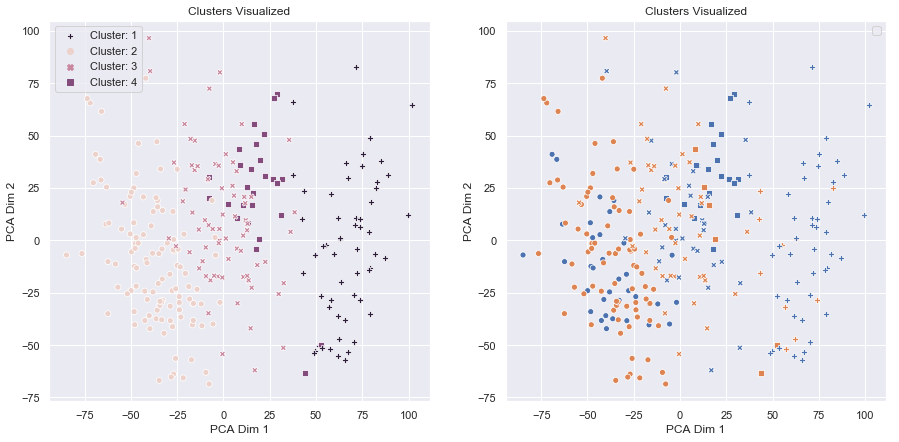

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, ax=ax[0])
# sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, size=cluster_assignments, ax=ax[0])
ax[0].set_xlabel('PCA Dim 1')
ax[0].set_ylabel('PCA Dim 2')
ax[0].set_title('Clusters Visualized')
ax[0].legend([f'Cluster: {i+1}' for i in range(4)])

# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments, ax=ax[1])
# sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, size=cluster_assignments, ax=ax[1])
ax[1].set_xlabel('PCA Dim 1')
ax[1].set_ylabel('PCA Dim 2')
ax[1].set_title('Clusters Visualized')
ax[1].legend([])

#### Cluster Purity

Finding cluster purity based on the sleep labels

In [62]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster 
# to total number of instances in the cluster
for master_cluster_num in range(len(centres)):
    cluster_sleep_labels = final_sleep_labels[cluster_assignments == master_cluster_num]
    pos_sleep_label_purity = sum(cluster_sleep_labels) / cluster_sleep_labels.shape[0]
    print(f'Cluster Number: {master_cluster_num}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))

Cluster Number: 0, Purity: 0.6902654867256637
Cluster Number: 1, Purity: 0.5657894736842105
Cluster Number: 2, Purity: 0.7777777777777778
Cluster Number: 3, Purity: 0.8214285714285714


Text(0.5, 1.0, 'Cluster 4')

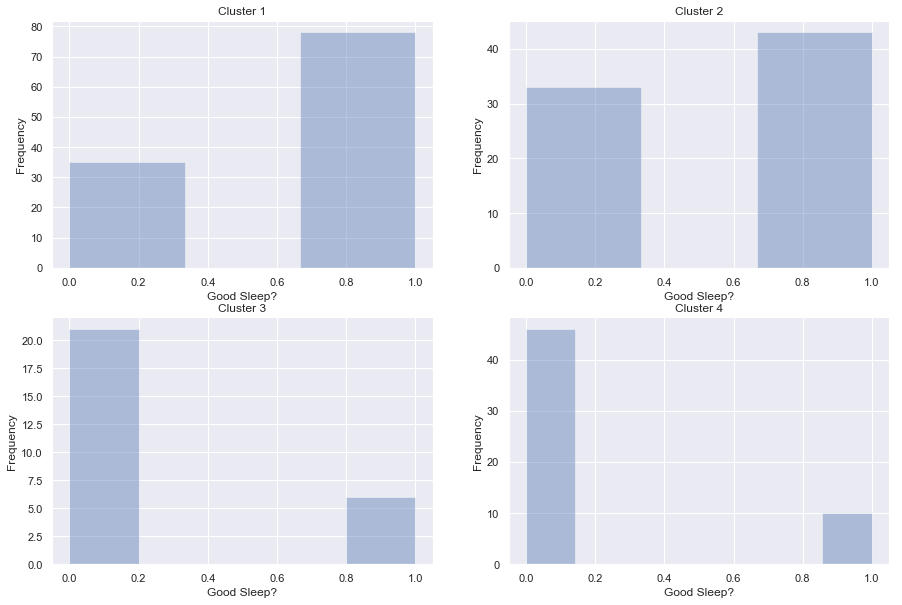

In [63]:
# Constructing a histogram plot for visualizing the sleep efficiency cluster purity in all cluster.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(np.array(final_sleep_labels[cluster_assignments==0], dtype=np.int16), ax = ax[0, 0], kde=False)
ax[0, 0].set_xlabel('Good Sleep?')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Cluster 1')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==1], dtype=np.int16), ax = ax[0, 1], kde=False)
ax[0, 1].set_xlabel('Good Sleep?')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Cluster 2')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==2], dtype=np.int16), ax = ax[1, 0], kde=False)
ax[1, 0].set_xlabel('Good Sleep?')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Cluster 3')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==3], dtype=np.int16), ax = ax[1, 1], kde=False)
ax[1, 1].set_xlabel('Good Sleep?')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Cluster 4')

#### Activity Histograms for Clusters

#### Cluster: 1

Text(0.5, 1.0, '% Vigorous Activity Histogram')

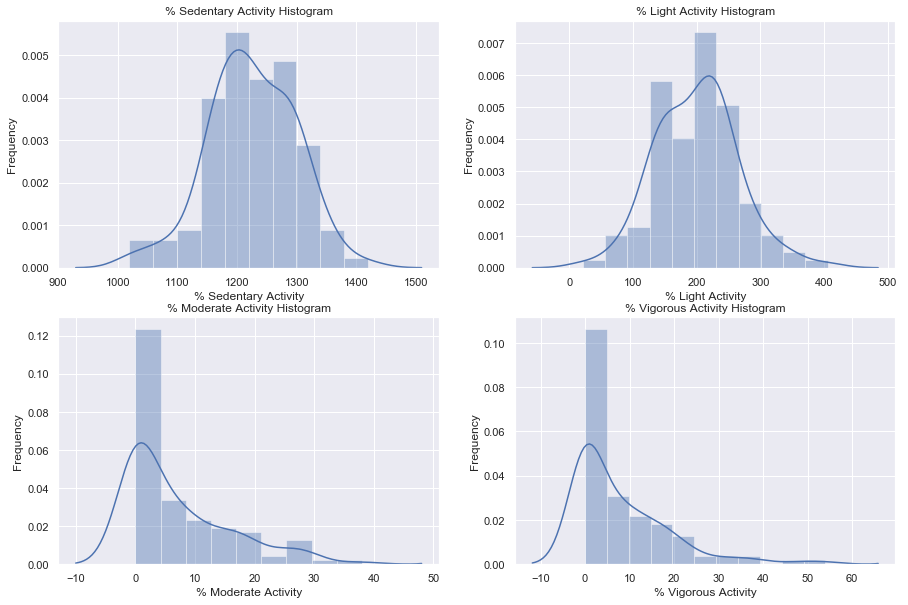

In [64]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

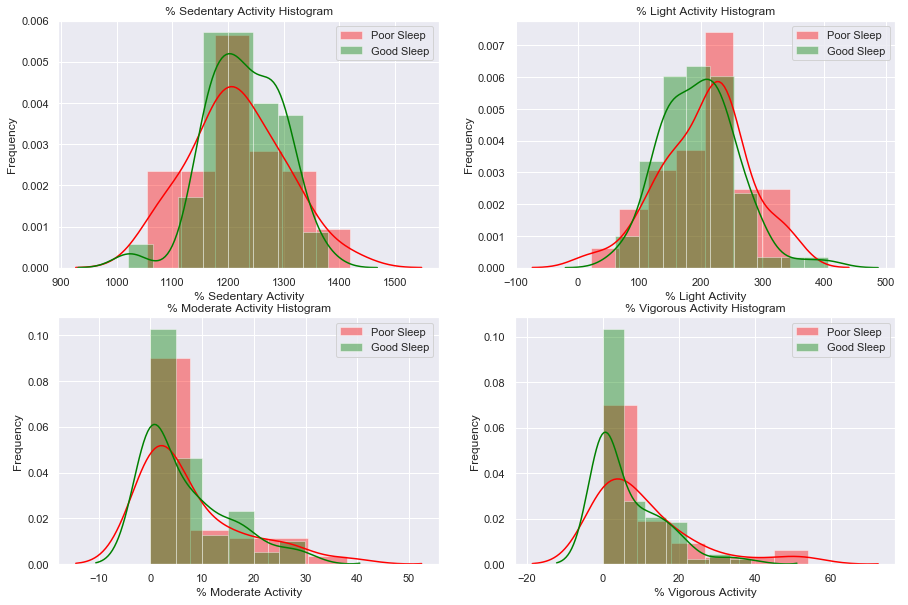

In [65]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 2

Text(0.5, 1.0, '% Vigorous Activity Histogram')

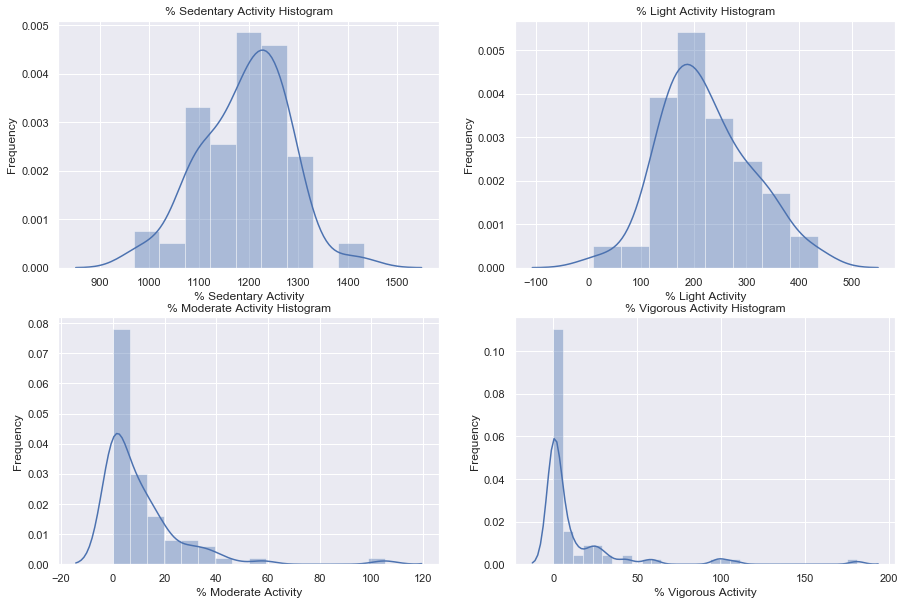

In [66]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

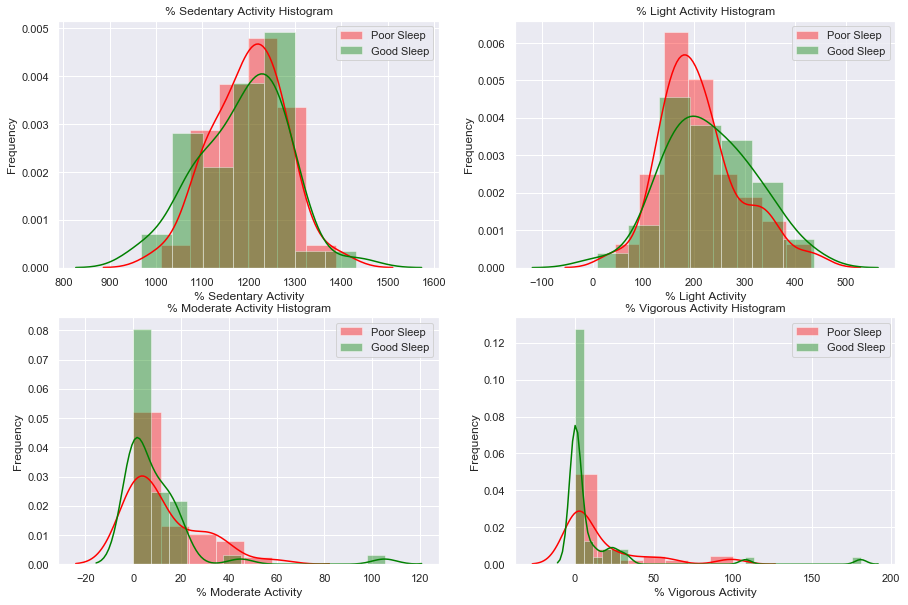

In [67]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 3

Text(0.5, 1.0, '% Vigorous Activity Histogram')

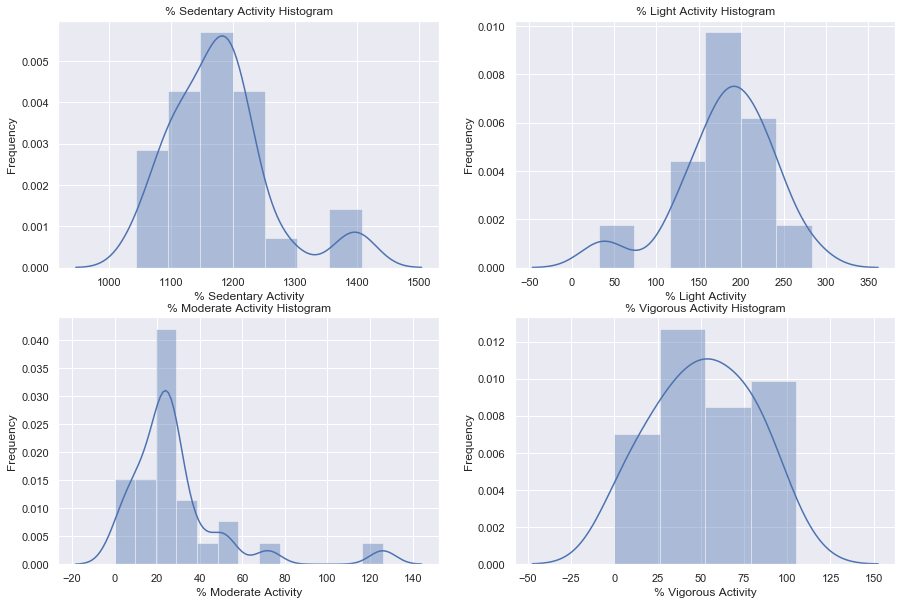

In [68]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

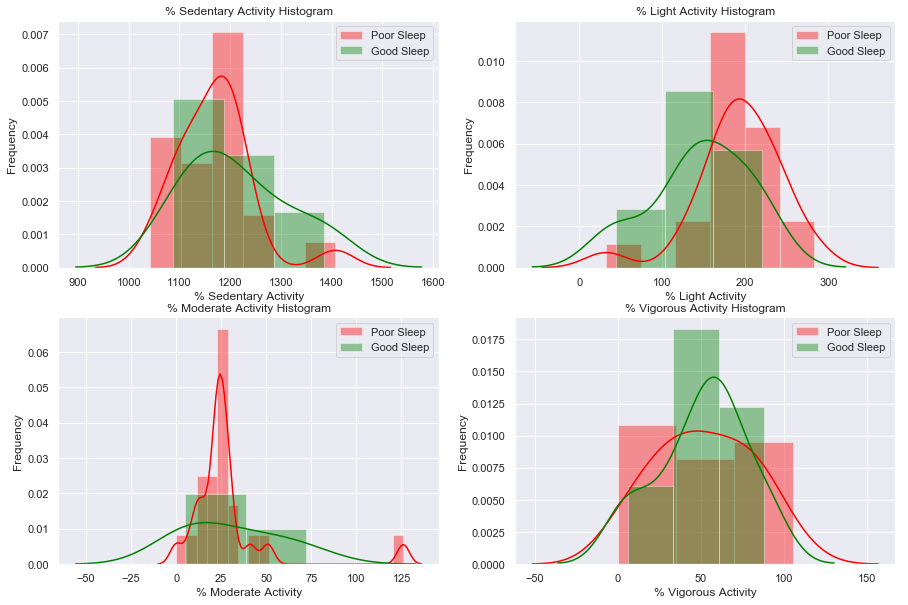

In [69]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 4

Text(0.5, 1.0, '% Vigorous Activity Histogram')

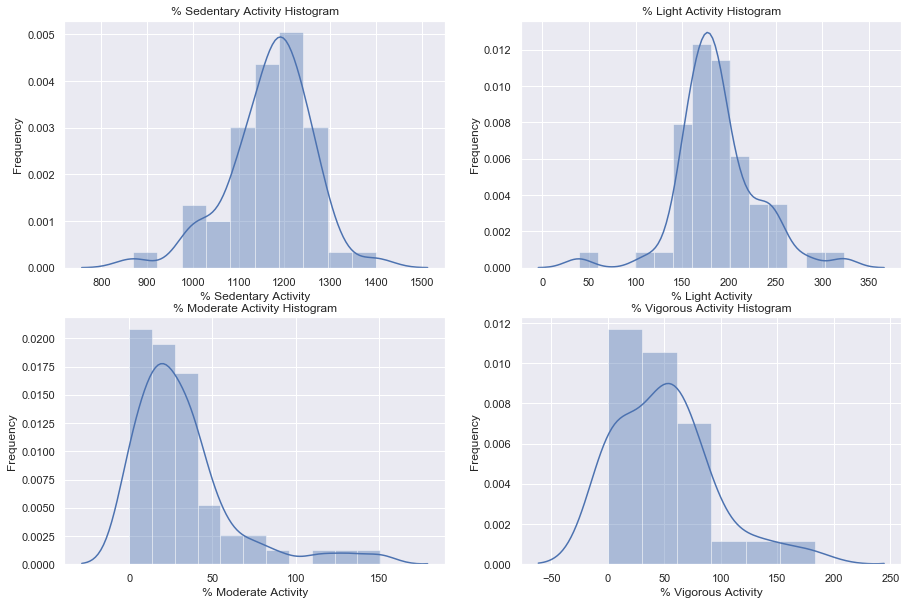

In [70]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

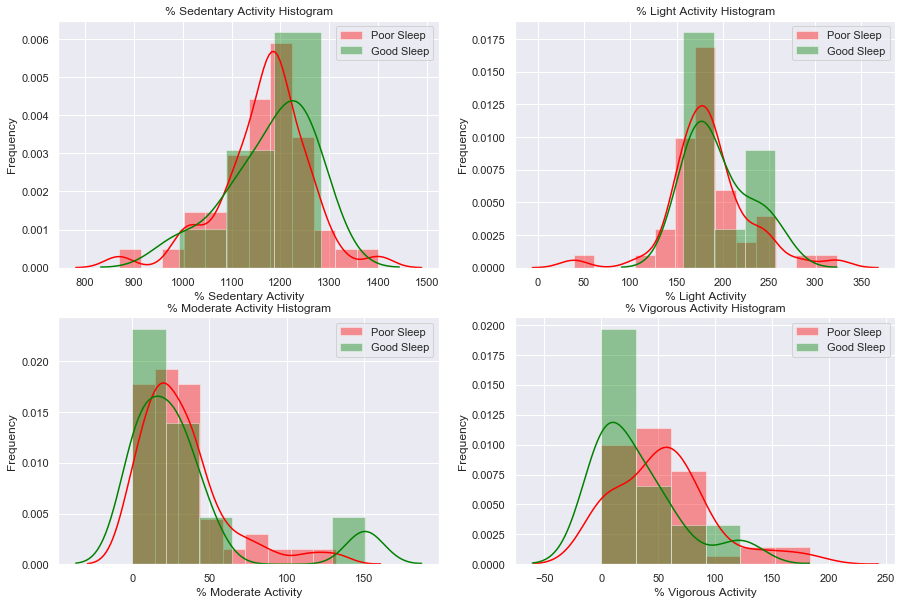

In [71]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Sub-Clustering on Activity Data

In [72]:
sub_clusters = activity_percentage_clusterer(KL_Kmeans(num_clusters=num_activity_clusters), cluster_assignments, activity_percentages)

kmeans: X (113, 4)  centres (8, 4)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AFF3CCF8>>
kmeans: 2 iterations  cluster sizes: [23  6  5 14 15 12 22 16]
kmeans: X (76, 4)  centres (8, 4)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AFF3CCF8>>
kmeans: 14 iterations  cluster sizes: [ 7  5  8  7 19  9 16  5]
kmeans: X (27, 4)  centres (8, 4)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AFF3CCF8>>
kmeans: 2 iterations  cluster sizes: [2 4 3 4 2 4 6 2]
kmeans: X (56, 4)  centres (8, 4)  delta=0.001  maxiter=100  metric=<bound method KL_Kmeans.k_l_distance of <kmeans_dm.KL_Kmeans object at 0x00000211AFF3CCF8>>
kmeans: 2 iterations  cluster sizes: [10  9  6  7  3  3  8 10]


In [73]:
# Sanity Check for the number of points in each cluster
print(np.unique(cluster_assignments, return_counts=True))
for sub_cluster in sub_clusters:
    print(sub_cluster.shape)

(array([0, 1, 2, 3], dtype=int64), array([113,  76,  27,  56], dtype=int64))
(113,)
(76,)
(27,)
(56,)


##### Cluster Purity in each subcluster

In [74]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster
# to total number of instances in the cluster
for index, sub_cluster in enumerate(sub_clusters):
    print('Master Cluster:', index+1)
    cluster_sleep_labels = final_sleep_labels[(cluster_assignments == index)]
    for sub_cluster_assignment in range(num_activity_clusters):
        sub_cluster_sleep_labels = cluster_sleep_labels[(sub_cluster==sub_cluster_assignment)]
        try:
            pos_sleep_label_purity = sum(sub_cluster_sleep_labels) / sub_cluster_sleep_labels.shape[0]
            print(f'Sub Cluster Number: {sub_cluster_assignment}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))
            print(f'Sub Cluster Number: {sub_cluster_assignment}, Good Sleep %:', pos_sleep_label_purity)
        except:
            print(f'Sub Cluster Number: {sub_cluster_assignment}, No Points assigned')

Master Cluster: 1
Sub Cluster Number: 0, Purity: 0.6521739130434783
Sub Cluster Number: 0, Good Sleep %: 0.6521739130434783
Sub Cluster Number: 1, Purity: 0.8333333333333334
Sub Cluster Number: 1, Good Sleep %: 0.8333333333333334
Sub Cluster Number: 2, Purity: 0.6
Sub Cluster Number: 2, Good Sleep %: 0.4
Sub Cluster Number: 3, Purity: 0.7142857142857143
Sub Cluster Number: 3, Good Sleep %: 0.7142857142857143
Sub Cluster Number: 4, Purity: 0.5333333333333333
Sub Cluster Number: 4, Good Sleep %: 0.5333333333333333
Sub Cluster Number: 5, Purity: 0.9166666666666666
Sub Cluster Number: 5, Good Sleep %: 0.9166666666666666
Sub Cluster Number: 6, Purity: 0.6818181818181818
Sub Cluster Number: 6, Good Sleep %: 0.6818181818181818
Sub Cluster Number: 7, Purity: 0.75
Sub Cluster Number: 7, Good Sleep %: 0.75
Master Cluster: 2
Sub Cluster Number: 0, Purity: 0.7142857142857143
Sub Cluster Number: 0, Good Sleep %: 0.7142857142857143
Sub Cluster Number: 1, Purity: 0.8
Sub Cluster Number: 1, Good Sleep

In [81]:
sleep_recipes = get_good_sleep_recipes(cluster_assignments, sub_clusters, activity_percentages, final_sleep_labels, good_sleep_ratio=1.)
sleep_recipes

Cluster: 0, Sub Cluster: 0, Good Ratio: 1.875
Cluster: 0, Sub Cluster: 1, Good Ratio: 5.0
Cluster: 0, Sub Cluster: 3, Good Ratio: 2.5
Cluster: 0, Sub Cluster: 4, Good Ratio: 1.1428571428571428
Cluster: 0, Sub Cluster: 5, Good Ratio: 11.0
Cluster: 0, Sub Cluster: 6, Good Ratio: 2.142857142857143
Cluster: 0, Sub Cluster: 7, Good Ratio: 3.0
Cluster: 1, Sub Cluster: 0, Good Ratio: 2.5
Cluster: 1, Sub Cluster: 1, Good Ratio: 4.0
Cluster: 1, Sub Cluster: 2, Good Ratio: 1.0
Cluster: 1, Sub Cluster: 5, Good Ratio: 1.25
Cluster: 1, Sub Cluster: 6, Good Ratio: 3.0
Cluster: 2, Sub Cluster: 0, Good Ratio: 1.0
Cluster: 2, Sub Cluster: 1, Good Ratio: 1.0
Cluster: 2, Sub Cluster: 4, Good Ratio: 1.0
Cluster: 2, Sub Cluster: 7, Good Ratio: 1.0
Cluster: 3, Sub Cluster: 5, Good Ratio: 2.0


array([[1192.3798   ,  231.11249  ,    6.749238 ,    9.571406 ],
       [1141.3801   ,  276.9975   ,   15.179062 ,    6.3935156],
       [1186.83     ,  253.09126  ,    0.       ,    0.       ],
       [1157.175    ,  237.1078   ,   19.87295  ,   26.012108 ],
       [1268.9182   ,  171.19432  ,    0.       ,    0.       ],
       [1252.08     ,  165.48375  ,   12.921797 ,    9.340137 ],
       [1308.       ,  131.9203   ,    0.       ,    0.       ],
       [1108.98     ,  320.66998  ,   10.396406 ,    0.       ],
       [1080.675    ,  343.74377  ,   10.981054 ,    4.4997807],
       [1119.8251   ,  276.30002  ,   23.217188 ,   20.485548 ],
       [1319.22     ,  120.81797  ,    0.       ,    0.       ],
       [1206.6      ,  233.25935  ,    0.       ,    0.       ],
       [1385.1      ,   44.071877 ,    5.041406 ,    6.046875 ],
       [1248.3      ,  129.43124  ,   20.014452 ,   42.46875  ],
       [1166.4      ,  193.95     ,   14.9765625,   65.08125  ],
       [1143.9      ,  15

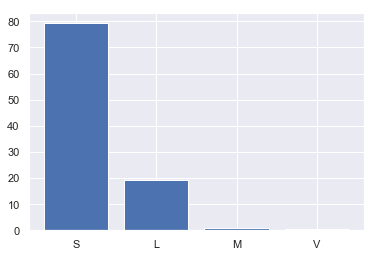

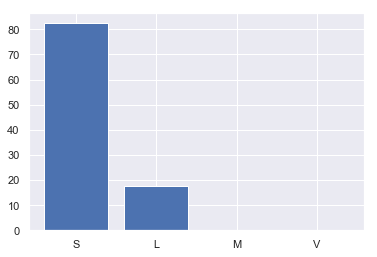

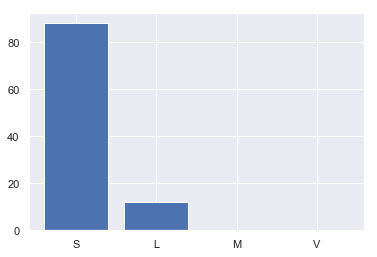

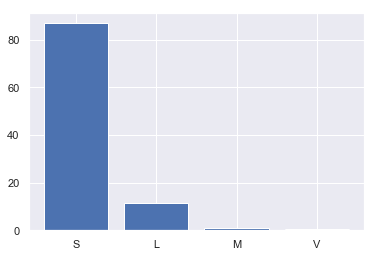

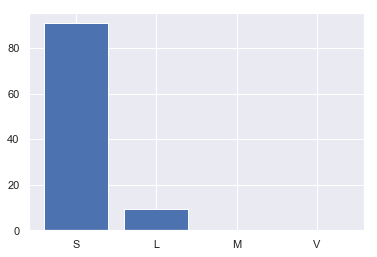

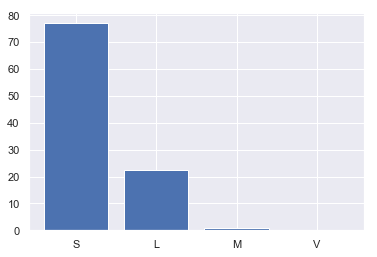

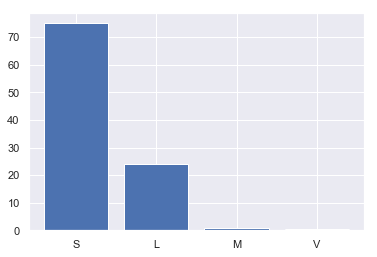

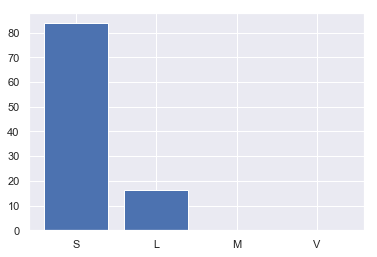

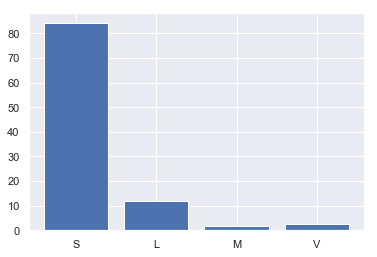

In [77]:
for i, sleep_recipe in enumerate(sleep_recipes):
    plt.figure(i)
    plt.bar(['S', 'L', 'M', 'V'], (sleep_recipe / 1440 * 100))